# Installation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install julia


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 2.4 MB/s eta 0:00:00


In [ ]:
!LD_LIBRARY_PATH=openssl

In [ ]:
!julia -e "using Pkg; Pkg.Registry.add(RegistrySpec(url=\"https://github.com/JuliaRegistries/General\"))"
!julia -e "using Pkg; Pkg.Registry.add(RegistrySpec(url=\"https://github.com/ACEsuit/ACEregistry\"))"

     Cloning registry from "https://github.com/JuliaRegistries/General"
       Added registry `General` to `~/.julia/registries/General`
     Cloning registry from "https://github.com/ACEsuit/ACEregistry"
       Added registry `ACE` to `~/.julia/registries/ACE`


In [ ]:
!julia -e "using Pkg; Pkg.add(Pkg.PackageSpec(;name=\"ACEpotentials\", version=\"0.6.5\"))" > /dev/null 2>&1

In [ ]:
!julia -e "using Pkg; Pkg.add(Pkg.PackageSpec(;name=\"ASE\", version=\"0.5.2\"))"

In [ ]:
!julia -e "using Pkg; Pkg.add(\"JuLIP\"); Pkg.add(\"ACE1\"); Pkg.add(\"PyCall\")"


   Resolving package versions...
    Updating `~/.julia/environments/v1.11/Project.toml`
⌅ [945c410c] + JuLIP v0.14.8
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`
   Resolving package versions...
    Updating `~/.julia/environments/v1.11/Project.toml`
  [e3f9bc04] + ACE1 v0.12.5
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`
   Resolving package versions...
    Updating `~/.julia/environments/v1.11/Project.toml`
  [438e738f] + PyCall v1.96.4
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`


In [ ]:
!git clone https://github.com/casv2/pyjulip.git
!cd pyjulip
!pip install ./pyjulip
!pip install ase

fatal: destination path 'pyjulip' already exists and is not an empty directory.
Processing ./pyjulip
  Preparing metadata (setup.py) ... done
  Created wheel for pyjulip: filename=pyjulip-0.1-py3-none-any.whl size=2165 sha256=dd7440888576f24ee3cfb6653e97b70421396ac258c4f4347362bc4f8cbd8176
  Stored in directory: /tmp/pip-ephem-wheel-cache-uycny0qb/wheels/08/a5/6e/8d935e8077db3afb31fd57058df80493d810733bdf0bae136d
Successfully built pyjulip
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 32.7 MB/s eta 0:00:00


In [ ]:
!julia -e 'using ASE; ASEAtoms(a) = ASE.ASEAtoms(a)'

In [ ]:
!LD_LIBRARY_PATH=openssl

In [ ]:
import julia; julia.install()

# ACE Calculator

In [ ]:
# At first attempt, it gives an error, then I have to run again the two before cells: !LD_LIBRARY_PATH=openssl  And import julia; julia.install() then run this cell

import numpy as np
from ase.calculators.calculator import Calculator
import tempfile
import os

# --- Initialize Julia ---
from julia.api import Julia
jl = Julia(compiled_modules=False)

from julia import Main
Main.eval("using ASE, JuLIP, ACE1, ACEpotentials")

# --- Define helper function for stress in Voigt form ---
Main.eval("""
function voigt_stress(model, at)
    s = stress(model, at)
    return [s[1,1], s[2,2], s[3,3], s[2,3], s[1,3], s[1,2]]
end
""")

# --- ACE1 loader with flexible path and error handling ---
def ACE1(pot_path):
    try:
        Main.eval(f"D = load_dict(\"{pot_path}\")")
        model = Main.eval("read_dict(D[\"IP\"])")
    except Exception:
        model = Main.eval("read_dict(D[\"potential\"])")
    return JulipCalculator(model)

# --- ASE-compatible calculator using the ACE model ---
class JulipCalculator(Calculator):
    implemented_properties = ['energy', 'forces', 'free_energy', 'stress']
    default_parameters = {}
    name = 'JulipCalculator'

    def __init__(self, model):
        Calculator.__init__(self)
        assert model is not None, "Model must be provided and not None"
        self.model = model  # Julia model object

    def calculate(self, atoms, properties, system_changes):
        Calculator.calculate(self, atoms, properties, system_changes)
        self.results = {}

        # Write atoms to a temporary .xyz file
        with tempfile.NamedTemporaryFile(suffix=".xyz", delete=False) as tmpfile:
            atoms.write(tmpfile.name)
            xyz_path = tmpfile.name

        try:
            # Send model and structure to Julia
            Main.model = self.model
            Main.eval(f"xyz = read_extxyz(\"{xyz_path}\")")

            if 'energy' in properties:
                energy = Main.eval("energy(model, xyz[1])")
                self.results['energy'] = energy
                self.results['free_energy'] = energy

            if 'forces' in properties:
                forces = Main.eval("forces(model, xyz[1])")
                self.results['forces'] = np.array(forces)

            if 'stress' in properties:
                stress = Main.eval("voigt_stress(model, xyz[1])")
                self.results['stress'] = np.array(stress)

        except Exception as e:
            print(f"Error during calculation: {e}")
            raise

        finally:
            os.remove(xyz_path)


In [ ]:
import ase
import pyjulip

#Test

calc = ACE1("sample_ACE_model.json")

md = ase.io.read('md_tungsten_bulk_N16_steps1000000_interval5000_T800.xyz', ':')

for m in md[0:10]:
  m.calc = calc
  print(m.get_forces())

md[1].get_potential_energy()
md[3].get_forces()

[[ 3.89226429e-11 -1.41797130e-11  2.13766782e-11]
 [ 2.97568636e-11 -2.61524136e-12  2.42654785e-11]
 [ 3.88522547e-11 -1.41705536e-11 -2.14154805e-11]
 [ 2.97719627e-11 -2.64666067e-12 -2.42383891e-11]
 [ 3.89172028e-11  1.41082701e-11  2.13870033e-11]
 [ 2.97588620e-11  2.73203552e-12  2.42824649e-11]
 [ 3.89428559e-11  1.41219536e-11 -2.14140650e-11]
 [ 2.97468716e-11  2.65598654e-12 -2.42299514e-11]
 [-3.89298593e-11 -1.41609779e-11  2.13590257e-11]
 [-2.96627228e-11 -2.64016586e-12  2.42694198e-11]
 [-3.89806659e-11 -1.42008558e-11 -2.14141205e-11]
 [-2.97073477e-11 -2.62026512e-12 -2.42716958e-11]
 [-3.89869144e-11  1.41211175e-11  2.13891266e-11]
 [-2.96707775e-11  2.67696607e-12  2.42752485e-11]
 [-3.89249744e-11  1.41149314e-11 -2.14130935e-11]
 [-2.96789260e-11  2.68940425e-12 -2.42303955e-11]]
[[ 6.75888755e-01 -3.69966948e-01 -1.19996975e+00]
 [-1.10318266e+00 -5.49418556e-01  7.00393716e-01]
 [-1.71065764e+00  1.25419369e+00 -7.81107604e-01]
 [-1.52024644e+00  7.25746641e

# Benchmark tests from A.13 of MACE MP paper

## Chapter 4

### W

#### Lattice Constant

In [ ]:
from ase.build import bulk
from ase.constraints import UnitCellFilter
from numpy.linalg import norm
from ase.optimize import BFGS
from ase.io import write
import numpy as np

element_symbol = "W"
crystal = "bcc"
initial_lattice = 3.0
supercell = (3, 3, 3)
num_spercell_x = supercell[0]
# --- Perform structure + cell optimization ---
atoms = bulk(element_symbol, crystal, a=initial_lattice)*supercell


# Potential path

potential_path = "/ACEcalculator&MACE MP A13 benchmarks/W_Dataset_order4_totaldegree9_rcut4.5_md_tungsten_bulk_N16_steps1500000_interval500_Tmix_W_3.188_bcc_training_data_176strs.json"

#potential_path ="/ACEcalculator&MACE MP A13 benchmarks/W_Dataset_order4_totaldegree9_rcut4.5_DFT.json"

#potential_path ="/ACEcalculator&MACE MP A13 benchmarks/W_Dataset_order4_totaldegree9_rcut4.5_W_A13_DFT_configs_with_MD_MACEL1calculator.json"
#potential_path ="/ACEcalculator&MACE MP A13 benchmarks/W_Dataset_order4_totaldegree9_rcut4.5_W_A13_DFT_configs_with_MD_MACE_FTcalculator.json"

#potential_path = "/ACEcalculator&MACE MP A13 benchmarks/W_Dataset_order4_totaldegree9_rcut4.5_RRR_synthetic_structures_of_evwindow&vacancy250relaxed_npr5_T300_beta0.2_sig0.010.1_mf30_ms0.5_mr20_nonparents.json"

#potential_path = "/ACEcalculator&MACE MP A13 benchmarks/W_Dataset_order4_totaldegree9_rcut4.5_random_disp_aug_of_evwindowbccfcc_m2_delta0.4&vacancy250relaxed.json"
#potential_path = "/ACEcalculator&MACE MP A13 benchmarks/W_Dataset_order4_totaldegree9_rcut4.5_random_disp_aug_of_evwindowbccfcc_m2_delta0.4&of_relaxedvacancy250.json"


atoms.calc = ACE1(potential_path)

ucf = UnitCellFilter(atoms, hydrostatic_strain=True)
opt = BFGS(ucf, trajectory="cell_relax.traj", logfile="cell_relax.log")
opt.run(fmax=0.01)

# --- Output relaxed cell and lattice constant ---
relaxed_cell = atoms.get_cell()

relaxed_a = atoms.get_cell()[0][0]/(num_spercell_x/2)


print("Relaxed cell:\n", relaxed_cell)
print(f"Relaxed lattice constant a = {relaxed_a:.5f} Å")

#write("relaxed_cell.xyz", atoms)


/tmp/ipython-input-681635759.py:70: FutureWarning: Import UnitCellFilter from ase.filters
  ucf = UnitCellFilter(atoms, hydrostatic_strain=True)


Relaxed cell:
 Cell([[-4.671216743701451, 4.671216743701451, 4.671216743701451], [4.671216743701451, -4.671216743701451, 4.671216743701451], [4.671216743701451, 4.671216743701451, -4.67121674370145]])
Relaxed lattice constant a = -3.11414 Å


#### Cubic elastic constants

In [ ]:
import numpy as np
from ase.build import bulk
from ase.units import GPa
from copy import deepcopy
from ase.optimize import BFGS
from ase.calculators.calculator import Calculator
import os

# Potential path
potential_path = "/ACEcalculator&MACE MP A13 benchmarks/W_Dataset_order4_totaldegree9_rcut4.5_md_tungsten_bulk_N16_steps1500000_interval500_Tmix_W_3.188_bcc_training_data_176strs.json"

#potential_path ="/ACEcalculator&MACE MP A13 benchmarks/W_Dataset_order4_totaldegree9_rcut4.5_DFT.json"

#potential_path ="/ACEcalculator&MACE MP A13 benchmarks/W_Dataset_order4_totaldegree9_rcut4.5_W_A13_DFT_configs_with_MD_MACEL1calculator.json"
#potential_path ="/ACEcalculator&MACE MP A13 benchmarks/W_Dataset_order4_totaldegree9_rcut4.5_W_A13_DFT_configs_with_MD_MACE_FTcalculator.json"

#potential_path = "/ACEcalculator&MACE MP A13 benchmarks/W_Dataset_order4_totaldegree9_rcut4.5_RRR_synthetic_structures_of_evwindow&vacancy250relaxed_npr5_T300_beta0.2_sig0.010.1_mf30_ms0.5_mr20_nonparents.json"

#potential_path = "/ACEcalculator&MACE MP A13 benchmarks/W_Dataset_order4_totaldegree9_rcut4.5_random_disp_aug_of_evwindowbccfcc_m2_delta0.4&vacancy250relaxed.json"
#potential_path = "/ACEcalculator&MACE MP A13 benchmarks/W_Dataset_order4_totaldegree9_rcut4.5_random_disp_aug_of_evwindowbccfcc_m2_delta0.4&of_relaxedvacancy250.json"




# === Julia Setup ===
from julia.api import Julia
jl = Julia(compiled_modules=False)
from julia import Main
# ---------------------------
# Setup: Load model and atoms
# ---------------------------
atoms = bulk("W", "bcc", a=3.188)
atoms.calc = ACE1(potential_path)

E0 = atoms.get_potential_energy()
V0 = atoms.get_volume()

# ---------------------------
# Helper Functions
# ---------------------------
def apply_strain(atoms, strain_matrix):
    strained_atoms = atoms.copy()
    cell = strained_atoms.get_cell()
    new_cell = cell @ (np.eye(3) + strain_matrix)
    strained_atoms.set_cell(new_cell, scale_atoms=True)
    strained_atoms.calc = ACE1(potential_path)  # Reassign ACE calculator
    return strained_atoms


def fit_elastic_constant(strain_list, energy_list, factor=1.0):
    x = np.array([d**2 for d in strain_list])
    y = np.array(energy_list)
    coeffs = np.polyfit(x, y, 1)
    A = coeffs[0]
    #return 2 * A / factor
    return A / factor

# ---------------------------
# C11: Uniaxial strain in xx
# ---------------------------
deltas = np.linspace(-0.005, 0.005, 10)
E_C11 = []

for delta in deltas:
    strain = np.zeros((3, 3))
    strain[0, 0] = delta
    strained = apply_strain(atoms, strain)
    E = strained.get_potential_energy()
    E_C11.append((E - E0) / V0)

C11 = fit_elastic_constant(deltas, E_C11, factor=1/2)

# ---------------------------
# C12: Orthorhombic strain
# ---------------------------
E_C12 = []

for delta in deltas:
    strain = np.zeros((3, 3))
    strain[0, 0] = delta
    strain[1, 1] = -delta
    strained = apply_strain(atoms, strain)
    E = strained.get_potential_energy()
    E_C12.append((E - E0) / V0)

C11_minus_C12 = fit_elastic_constant(deltas, E_C12, factor=1.0)
C12 = C11 - C11_minus_C12

# ---------------------------
# C44: Shear strain (xy)
# ---------------------------
E_C44 = []

for delta in deltas:
    strain = np.zeros((3, 3))
    strain[0, 1] = strain[1, 0] = delta  # symmetric shear
    strained = apply_strain(atoms, strain)
    E = strained.get_potential_energy()
    E_C44.append((E - E0) / V0)

C44 = fit_elastic_constant(deltas, E_C44, factor=2.0)

# ---------------------------
# Convert and Print
# ---------------------------
eV_per_A3_to_GPa = GPa

print("\nElastic Constants (from ACE model):")
print(f"C11 ≈ {C11 / eV_per_A3_to_GPa:.2f} GPa")
print(f"C12 ≈ {C12 / eV_per_A3_to_GPa:.2f} GPa")
print(f"C44 ≈ {C44 / eV_per_A3_to_GPa:.2f} GPa")



Elastic Constants (from ACE model):
C11 ≈ 326.19 GPa
C12 ≈ 256.48 GPa
C44 ≈ 98.73 GPa


#### Energy vs Volume

Saved ΔE–V data to DeltaE_vs_V_W_W_Dataset_order4_totaldegree9_rcut4.5_md_tungsten_bulk_N16_steps1500000_interval500_Tmix_W_3.188_bcc_training_data_176strs.csv


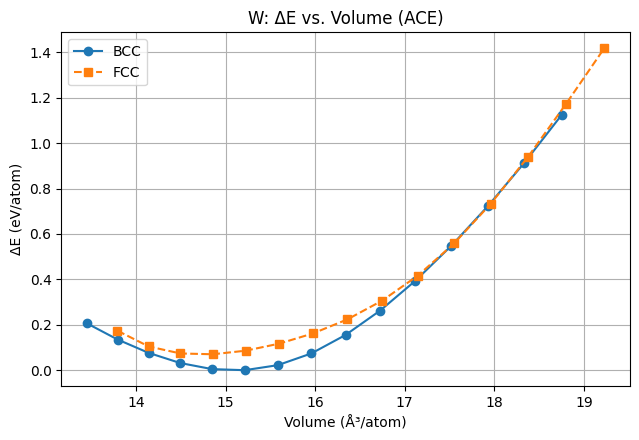

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from ase.build import bulk
import os

# === Setup ===
element = "W"
a0_bcc = 3.188
a0_fcc = 4.05
scaling_factors = np.linspace(0.94, 1.05, 15)  # example: ±6% around a0

# Potential path
#potential_path ="/content/drive/MyDrive/Colab_files/Thesis/ACE/ACE Calculator & Reproduce A13 results ACE/W_Dataset_order4_totaldegree9_rcut4.5_DFT.json"
#potential_path ="/content/drive/MyDrive/Colab_files/Thesis/ACE/ACE Calculator & Reproduce A13 results ACE/W_Dataset_order4_totaldegree9_rcut4.5_W_A13_DFT_configs_with_MD_MACE_FTcalculator.json"
#potential_path ="/content/drive/MyDrive/Colab_files/Thesis/ACE/ACE Calculator & Reproduce A13 results ACE/W_Dataset_order4_totaldegree9_rcut4.5_W_A13_DFT_configs_with_MD_MACEL1calculator.json"



potential_path = "/content/drive/MyDrive/Colab_files/Thesis/ACE/ACE Calculator & Reproduce A13 results ACE/W_Dataset_order4_totaldegree9_rcut4.5_md_tungsten_bulk_N16_steps1500000_interval500_Tmix_W_3.188_bcc_training_data_176strs.json"

#potential_path = "/content/drive/MyDrive/Colab_files/Thesis/ACE/ACE Calculator & Reproduce A13 results ACE/W_Dataset_order4_totaldegree9_rcut4.5_RRR_synthetic_structures_of_evwindow&vacancy250relaxed_npr5_T300_beta0.2_sig0.010.1_mf30_ms0.5_mr20_nonparents.json"

#potential_path = "/content/drive/MyDrive/Colab_files/Thesis/ACE/ACE Calculator & Reproduce A13 results ACE/W_Dataset_order4_totaldegree9_rcut4.5_random_disp_aug_of_evwindowbccfcc_m2_delta0.4&vacancy250relaxed.json"
#potential_path = "/content/drive/MyDrive/Colab_files/Thesis/ACE/ACE Calculator & Reproduce A13 results ACE/W_Dataset_order4_totaldegree9_rcut4.5_random_disp_aug_of_evwindowbccfcc_m2_delta0.4&of_relaxedvacancy250.json"







# Load ACE calculator
calc = ACE1(potential_path)

# === Energy vs Volume ===
def compute_e_vs_v(crystal, a0):
    volumes, energies = [], []
    for scale in scaling_factors:
        atoms = bulk(element, crystal, a=a0 * scale)
        atoms.calc = calc
        E_per_atom = atoms.get_potential_energy() / len(atoms)
        V_per_atom = atoms.get_volume() / len(atoms)
        volumes.append(V_per_atom)
        energies.append(E_per_atom)
    return np.array(volumes), np.array(energies)

# Compute curves
vol_bcc, en_bcc = compute_e_vs_v("bcc", a0_bcc)
vol_fcc, en_fcc = compute_e_vs_v("fcc", a0_fcc)

# === Shift to DeltaE (relative to BCC minimum) ===
E_ref = en_bcc.min()
delta_en_bcc = en_bcc - E_ref
delta_en_fcc = en_fcc - E_ref

# === Save to CSV (name based on model) ===
model_name = os.path.splitext(os.path.basename(potential_path))[0]
out_csv = f"DeltaE_vs_V_W_{model_name}.csv"

df = pd.DataFrame({
    "V_BCC": vol_bcc,
    "DeltaE_BCC": delta_en_bcc,
    "V_FCC": vol_fcc,
    "DeltaE_FCC": delta_en_fcc
})
df.to_csv(out_csv, index=False)
print(f"Saved ΔE–V data to {out_csv}")

# === Plot ===
plt.figure(figsize=(6.5, 4.5))
plt.plot(vol_bcc, delta_en_bcc, 'o-', label="BCC")
plt.plot(vol_fcc, delta_en_fcc, 's--', label="FCC")
plt.xlabel("Volume (Å³/atom)")
plt.ylabel("ΔE (eV/atom)")
plt.title(f"{element.upper()}: ΔE vs. Volume (ACE)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


#### Vacancy formation energy

In [ ]:
from ase.build import bulk
from ase.constraints import UnitCellFilter
from numpy.linalg import norm
from ase.optimize import BFGS
from ase.io import write
import numpy as np

# === Vacancy Formation Calculation ===

# Parameters
element = "W"
a0 = 3.188
supercell_size = (5, 5, 5)
fmax_tol = 1e-1


# Potential path
potential_path = "/ACEcalculator&MACE MP A13 benchmarks/W_Dataset_order4_totaldegree9_rcut4.5_md_tungsten_bulk_N16_steps1500000_interval500_Tmix_W_3.188_bcc_training_data_176strs.json"

#potential_path ="/ACEcalculator&MACE MP A13 benchmarks/W_Dataset_order4_totaldegree9_rcut4.5_DFT.json"

#potential_path ="/ACEcalculator&MACE MP A13 benchmarks/W_Dataset_order4_totaldegree9_rcut4.5_W_A13_DFT_configs_with_MD_MACEL1calculator.json"
#potential_path ="/ACEcalculator&MACE MP A13 benchmarks/W_Dataset_order4_totaldegree9_rcut4.5_W_A13_DFT_configs_with_MD_MACE_FTcalculator.json"

#potential_path = "/ACEcalculator&MACE MP A13 benchmarks/W_Dataset_order4_totaldegree9_rcut4.5_RRR_synthetic_structures_of_evwindow&vacancy250relaxed_npr5_T300_beta0.2_sig0.010.1_mf30_ms0.5_mr20_nonparents.json"

#potential_path = "/ACEcalculator&MACE MP A13 benchmarks/W_Dataset_order4_totaldegree9_rcut4.5_random_disp_aug_of_evwindowbccfcc_m2_delta0.4&vacancy250relaxed.json"
#potential_path = "/ACEcalculator&MACE MP A13 benchmarks/W_Dataset_order4_totaldegree9_rcut4.5_random_disp_aug_of_evwindowbccfcc_m2_delta0.4&of_relaxedvacancy250.json"



# --- Build and relax bulk supercell ---
atoms_bulk = bulk(element, 'bcc', a=a0, cubic=True).repeat(supercell_size)
N_bulk = len(atoms_bulk)

atoms_bulk.calc = ACE1(potential_path)
opt_bulk = BFGS(atoms_bulk, logfile=None)
opt_bulk.run(fmax=fmax_tol)

E_bulk = atoms_bulk.get_potential_energy()
print(f"Bulk energy (N={N_bulk}): {E_bulk:.3f} eV")

# --- Create and relax vacancy structure ---
atoms_vac = atoms_bulk.copy()
atoms_vac.pop(len(atoms_vac) // 2)
atoms_vac.calc = ACE1(potential_path)

opt_vac = BFGS(atoms_vac, logfile=None)
opt_vac.run(fmax=fmax_tol)

E_vac = atoms_vac.get_potential_energy()

# --- Calculate vacancy formation energy ---
vac_E = E_vac - ((N_bulk - 1) / N_bulk) * E_bulk
print(f"Vacancy formation energy: {vac_E:.3f} eV")

Bulk energy (N=250): -3193.706 eV
Vacancy formation energy: 2.386 eV


## Chapter 5

### W

#### Lattice Constant

In [ ]:
import pandas as pd
from ase.io import read, write
from ase.build import bulk
from ase.constraints import UnitCellFilter
from numpy.linalg import norm
from ase.optimize import BFGS
import numpy as np
import os

# -----------------------------
# SETTINGS
# -----------------------------
"""
# Uncomment for 352 strs
param_file = "/fit ACE model/saved models/Chapter5/trained on RVD dataset/m4_delta0.4_352strs/RRQR solver/resultsrandom_disp_aug_of_evwindowbccfcc_m4_delta0.4&of_relaxedvacancy250_withoutLatt3.188_RRQR.csv"
model_dir  = "/fit ACE model/saved models/Chapter5/trained on RVD dataset/m4_delta0.4_352strs/RRQR solver"
dataset_name = "W_random_disp_aug_of_evwindowbccfcc_m4_delta0.4&of_relaxedvacancy250_withoutLatt3.188"
"""

"""
# Uncomment for 176 strs
param_file = "/fit ACE model/saved models/Chapter5/trained on RVD dataset/m2_delta0.4_176strs/RRQR solver/resultsrandom_disp_aug_of_evwindowbccfcc_m2_delta0.4&of_relaxedvacancy250_withoutLatt3.188_RRQR.csv"
model_dir  = "/fit ACE model/saved models/Chapter5/trained on RVD dataset/m2_delta0.4_176strs/RRQR solver"
dataset_name = "W_random_disp_aug_of_evwindowbccfcc_m2_delta0.4&of_relaxedvacancy250_withoutLatt3.188"
"""

"""
# Uncomment for 88 strs
param_file = "/fit ACE model/saved models/Chapter5/trained on RVD dataset/m2_delta0.4_88strs/RRQR solver/resultsrandom_disp_aug_of_evwindowbccfcc_m2_delta0.4&of_relaxedvacancy250_withoutLatt3.188_88strs_RRQR.csv"
model_dir  = "/fit ACE model/saved models/Chapter5/trained on RVD dataset/m2_delta0.4_88strs/RRQR solver"
dataset_name = "W_random_disp_aug_of_evwindowbccfcc_m2_delta0.4&of_relaxedvacancy250_withoutLatt3.188_88strs"
"""

output_dir   ="/ACEcalculator&MACE MP A13 benchmarks/Chapter 5/W"





out_file   = f"Lattice_constant_{dataset_name}.csv"

element_symbol = "W"
crystal = "bcc"
initial_lattice = 3.0
supercell = (3, 3, 3)
num_spercell_x = supercell[0]
# --- Perform structure + cell optimization ---
atoms = bulk(element_symbol, crystal, a=initial_lattice)*supercell


# -----------------------------
# READ PARAMETER FILE
# -----------------------------
params = pd.read_csv(param_file)

# -----------------------------
# RESULTS CONTAINER
# -----------------------------
results = {
    "order": [],
    "totaldegree": [],
    "rcut": [],
    "Lattice Constant": []
}

# -----------------------------
# LOOP OVER MODELS
# -----------------------------
for _, row in params.iterrows():
    order = int(row["order"])
    totaldegree = int(row["totaldegree"])
    rcut = float(row["rcut"])

    #potential_path = os.path.join(model_dir,f"W_{dataset_name}_order{order}_totaldegree{totaldegree}_rcut{rcut}.json")
    potential_path = os.path.join(model_dir,f"{dataset_name}_order{order}_totaldegree{totaldegree}_rcut{rcut}.json")

    print(f"\nLoading model: {potential_path}")
    atoms.calc = ACE1(potential_path)

    ucf = UnitCellFilter(atoms, hydrostatic_strain=True)
    opt = BFGS(ucf, trajectory="cell_relax.traj", logfile="cell_relax.log")
    opt.run(fmax=0.1)

    # --- Output relaxed cell and lattice constant ---
    relaxed_cell = atoms.get_cell()

    relaxed_a = atoms.get_cell()[0][0]/(num_spercell_x/2)


    print("Relaxed cell:\n", relaxed_cell)
    print(f"Relaxed lattice constant of Order:{order}, Totaldegree{totaldegree}, Cutoff{rcut} = {relaxed_a:.5f} Å")




    # Store results
    results["order"].append(order)
    results["totaldegree"].append(totaldegree)
    results["rcut"].append(rcut)




    results["Lattice Constant"].append(relaxed_a)

# -----------------------------
# SAVE TO CSV
# -----------------------------
df_results = pd.DataFrame(results)
df_results.to_csv(os.path.join(output_dir, out_file), index=False)

print(f"\nSaved timings to {out_file}")



Loading model: /content/drive/MyDrive/Colab_files/Thesis/ACE/fit ACE model/saved models/Chapter5/trained on RVD dataset/m2_delta0.4_88strs/RRQR solver/W_random_disp_aug_of_evwindowbccfcc_m2_delta0.4&of_relaxedvacancy250_withoutLatt3.188_88strs_order3_totaldegree3_rcut4.5.json


/tmp/ipython-input-2268026310.py:66: FutureWarning: Import UnitCellFilter from ase.filters
  ucf = UnitCellFilter(atoms, hydrostatic_strain=True)


Relaxed cell:
 Cell([[-4.662956910769966, 4.662956910769963, 4.662956910769966], [4.662956910769966, -4.662956910769963, 4.662956910769966], [4.662956910769966, 4.66295691076997, -4.662956910769966]])
Relaxed lattice constant of Order:3, Totaldegree3, Cutoff4.5 = -3.10864 Å

Loading model: /content/drive/MyDrive/Colab_files/Thesis/ACE/fit ACE model/saved models/Chapter5/trained on RVD dataset/m2_delta0.4_88strs/RRQR solver/W_random_disp_aug_of_evwindowbccfcc_m2_delta0.4&of_relaxedvacancy250_withoutLatt3.188_88strs_order3_totaldegree3_rcut7.5.json
Relaxed cell:
 Cell([[-4.753977272844786, 4.753977272844782, 4.753977272844786], [4.753977272844786, -4.753977272844782, 4.753977272844786], [4.753977272844786, 4.753977272844789, -4.753977272844786]])
Relaxed lattice constant of Order:3, Totaldegree3, Cutoff7.5 = -3.16932 Å

Loading model: /content/drive/MyDrive/Colab_files/Thesis/ACE/fit ACE model/saved models/Chapter5/trained on RVD dataset/m2_delta0.4_88strs/RRQR solver/W_random_disp_aug_o

#### Cubic elastic constants

In [ ]:
import numpy as np
from ase.build import bulk
from ase.units import GPa
from copy import deepcopy
from ase.optimize import BFGS
from ase.calculators.calculator import Calculator
import os




# -----------------------------
# SETTINGS
# -----------------------------

"""
# Uncomment for 352 strs
param_file = "/fit ACE model/saved models/Chapter5/trained on RVD dataset/m4_delta0.4_352strs/RRQR solver/resultsrandom_disp_aug_of_evwindowbccfcc_m4_delta0.4&of_relaxedvacancy250_withoutLatt3.188_RRQR.csv"
model_dir  = "/fit ACE model/saved models/Chapter5/trained on RVD dataset/m4_delta0.4_352strs/RRQR solver"
dataset_name = "W_random_disp_aug_of_evwindowbccfcc_m4_delta0.4&of_relaxedvacancy250_withoutLatt3.188"
"""

"""
# Uncomment for 176 strs
param_file = "/fit ACE model/saved models/Chapter5/trained on RVD dataset/m2_delta0.4_176strs/RRQR solver/resultsrandom_disp_aug_of_evwindowbccfcc_m2_delta0.4&of_relaxedvacancy250_withoutLatt3.188_RRQR.csv"
model_dir  = "/fit ACE model/saved models/Chapter5/trained on RVD dataset/m2_delta0.4_176strs/RRQR solver"
dataset_name = "W_random_disp_aug_of_evwindowbccfcc_m2_delta0.4&of_relaxedvacancy250_withoutLatt3.188"
"""

"""
# Uncomment for 88 strs
param_file = "/fit ACE model/saved models/Chapter5/trained on RVD dataset/m2_delta0.4_88strs/RRQR solver/resultsrandom_disp_aug_of_evwindowbccfcc_m2_delta0.4&of_relaxedvacancy250_withoutLatt3.188_88strs_RRQR.csv"
model_dir  = "/fit ACE model/saved models/Chapter5/trained on RVD dataset/m2_delta0.4_88strs/RRQR solver"
dataset_name = "W_random_disp_aug_of_evwindowbccfcc_m2_delta0.4&of_relaxedvacancy250_withoutLatt3.188_88strs"
"""



output_dir   ="/ACEcalculator&MACE MP A13 benchmarks/Chapter 5/W"

out_file   = f"Cubic_elastic_constants_{dataset_name}.csv"



# -----------------------------
# READ PARAMETER FILE
# -----------------------------
params = pd.read_csv(param_file)

# -----------------------------
# RESULTS CONTAINER
# -----------------------------
results = {
    "order": [],
    "totaldegree": [],
    "rcut": [],
    "C11": [],
    "C12": [],
    "C44": []
}


# -----------------------------
# LOOP OVER MODELS
# -----------------------------
for _, row in params.iterrows():
    order = int(row["order"])
    totaldegree = int(row["totaldegree"])
    rcut = float(row["rcut"])

    #potential_path = os.path.join(model_dir,f"W_{dataset_name}_order{order}_totaldegree{totaldegree}_rcut{rcut}.json")
    potential_path = os.path.join(model_dir,f"{dataset_name}_order{order}_totaldegree{totaldegree}_rcut{rcut}.json")

    print(f"\nLoading model: {potential_path}")




    # === Julia Setup ===
    from julia.api import Julia
    jl = Julia(compiled_modules=False)
    from julia import Main
    # ---------------------------
    # Setup: Load model and atoms
    # ---------------------------
    atoms = bulk("W", "bcc", a=3.188)
    atoms.calc = ACE1(potential_path)

    E0 = atoms.get_potential_energy()
    V0 = atoms.get_volume()


    # ---------------------------
    # Helper Functions
    # ---------------------------
    def apply_strain(atoms, strain_matrix):
        strained_atoms = atoms.copy()
        cell = strained_atoms.get_cell()
        new_cell = cell @ (np.eye(3) + strain_matrix)
        strained_atoms.set_cell(new_cell, scale_atoms=True)
        strained_atoms.calc = ACE1(potential_path)  # Reassign ACE calculator
        return strained_atoms


    def fit_elastic_constant(strain_list, energy_list, factor=1.0):
        x = np.array([d**2 for d in strain_list])
        y = np.array(energy_list)
        coeffs = np.polyfit(x, y, 1)
        A = coeffs[0]
        #return 2 * A / factor
        return A / factor

    # ---------------------------
    # C11: Uniaxial strain in xx
    # ---------------------------
    deltas = np.linspace(-0.005, 0.005, 10)
    E_C11 = []

    for delta in deltas:
        strain = np.zeros((3, 3))
        strain[0, 0] = delta
        strained = apply_strain(atoms, strain)
        E = strained.get_potential_energy()
        E_C11.append((E - E0) / V0)

    C11 = fit_elastic_constant(deltas, E_C11, factor=1/2)


    # ---------------------------
    # C12: Orthorhombic strain
    # ---------------------------
    E_C12 = []

    for delta in deltas:
        strain = np.zeros((3, 3))
        strain[0, 0] = delta
        strain[1, 1] = -delta
        strained = apply_strain(atoms, strain)
        E = strained.get_potential_energy()
        E_C12.append((E - E0) / V0)

    C11_minus_C12 = fit_elastic_constant(deltas, E_C12, factor=1.0)
    C12 = C11 - C11_minus_C12

    # ---------------------------
    # C44: Shear strain (xy)
    # ---------------------------
    E_C44 = []

    for delta in deltas:
        strain = np.zeros((3, 3))
        strain[0, 1] = strain[1, 0] = delta  # symmetric shear
        strained = apply_strain(atoms, strain)
        E = strained.get_potential_energy()
        E_C44.append((E - E0) / V0)

    C44 = fit_elastic_constant(deltas, E_C44, factor=2.0)

    # ---------------------------
    # Convert and Print
    # ---------------------------
    eV_per_A3_to_GPa = GPa

    results["order"].append(order)
    results["totaldegree"].append(totaldegree)
    results["rcut"].append(rcut)
    results["C11"].append(C11 / eV_per_A3_to_GPa)
    results["C12"].append(C12 / eV_per_A3_to_GPa)
    results["C44"].append(C44 / eV_per_A3_to_GPa)


    print("\nElastic Constants (from ACE model):")
    print(f"C11 ≈ {C11 / eV_per_A3_to_GPa:.2f} GPa")
    print(f"C12 ≈ {C12 / eV_per_A3_to_GPa:.2f} GPa")
    print(f"C44 ≈ {C44 / eV_per_A3_to_GPa:.2f} GPa")


# -----------------------------
# SAVE TO CSV
# -----------------------------
df_results = pd.DataFrame(results)
df_results.to_csv(os.path.join(output_dir, out_file), index=False)

print(f"\nSaved timings to {out_file}")


Loading model: /content/drive/MyDrive/Colab_files/Thesis/ACE/fit ACE model/saved models/Chapter5/trained on RVD dataset/m2_delta0.4_88strs/RRQR solver/W_random_disp_aug_of_evwindowbccfcc_m2_delta0.4&of_relaxedvacancy250_withoutLatt3.188_88strs_order3_totaldegree3_rcut4.5.json

Elastic Constants (from ACE model):
C11 ≈ 4.71 GPa
C12 ≈ 38.80 GPa
C44 ≈ 46.24 GPa

Loading model: /content/drive/MyDrive/Colab_files/Thesis/ACE/fit ACE model/saved models/Chapter5/trained on RVD dataset/m2_delta0.4_88strs/RRQR solver/W_random_disp_aug_of_evwindowbccfcc_m2_delta0.4&of_relaxedvacancy250_withoutLatt3.188_88strs_order3_totaldegree3_rcut7.5.json

Elastic Constants (from ACE model):
C11 ≈ 235.30 GPa
C12 ≈ 240.48 GPa
C44 ≈ 0.19 GPa

Loading model: /content/drive/MyDrive/Colab_files/Thesis/ACE/fit ACE model/saved models/Chapter5/trained on RVD dataset/m2_delta0.4_88strs/RRQR solver/W_random_disp_aug_of_evwindowbccfcc_m2_delta0.4&of_relaxedvacancy250_withoutLatt3.188_88strs_order3_totaldegree3_rcut10.5.

#### Energy vs Volume


Loading model: /content/drive/MyDrive/Colab_files/Thesis/ACE/fit ACE model/saved models/Chapter5/trained on RVD dataset/m2_delta0.4_88strs/RRQR solver/W_random_disp_aug_of_evwindowbccfcc_m2_delta0.4&of_relaxedvacancy250_withoutLatt3.188_88strs_order3_totaldegree3_rcut4.5.json
Saved ΔE–V data to DeltaE_V_W_W_random_disp_aug_of_evwindowbccfcc_m2_delta0.4&of_relaxedvacancy250_withoutLatt3.188_88strs_order3_totaldegree3_rcut4.5.csv


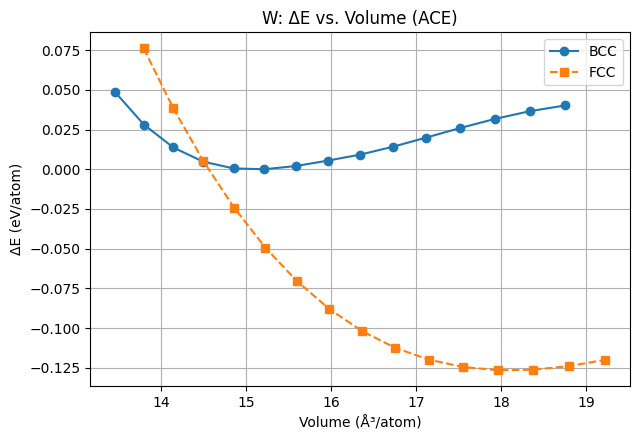


Loading model: /content/drive/MyDrive/Colab_files/Thesis/ACE/fit ACE model/saved models/Chapter5/trained on RVD dataset/m2_delta0.4_88strs/RRQR solver/W_random_disp_aug_of_evwindowbccfcc_m2_delta0.4&of_relaxedvacancy250_withoutLatt3.188_88strs_order3_totaldegree3_rcut7.5.json
Saved ΔE–V data to DeltaE_V_W_W_random_disp_aug_of_evwindowbccfcc_m2_delta0.4&of_relaxedvacancy250_withoutLatt3.188_88strs_order3_totaldegree3_rcut7.5.csv


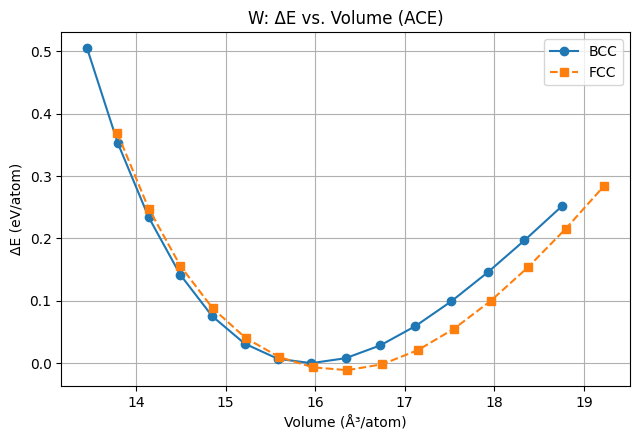


Loading model: /content/drive/MyDrive/Colab_files/Thesis/ACE/fit ACE model/saved models/Chapter5/trained on RVD dataset/m2_delta0.4_88strs/RRQR solver/W_random_disp_aug_of_evwindowbccfcc_m2_delta0.4&of_relaxedvacancy250_withoutLatt3.188_88strs_order3_totaldegree3_rcut10.5.json
Saved ΔE–V data to DeltaE_V_W_W_random_disp_aug_of_evwindowbccfcc_m2_delta0.4&of_relaxedvacancy250_withoutLatt3.188_88strs_order3_totaldegree3_rcut10.5.csv


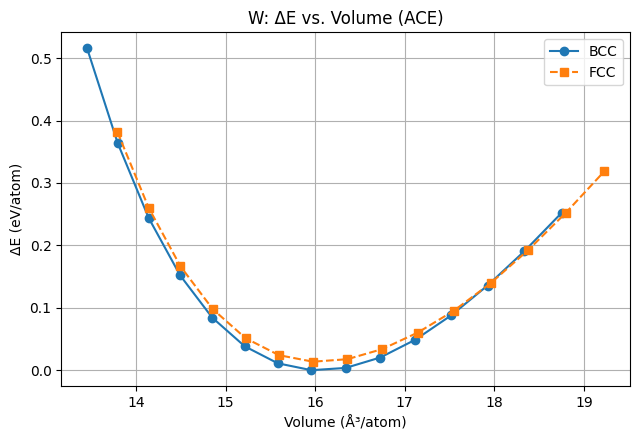


Loading model: /content/drive/MyDrive/Colab_files/Thesis/ACE/fit ACE model/saved models/Chapter5/trained on RVD dataset/m2_delta0.4_88strs/RRQR solver/W_random_disp_aug_of_evwindowbccfcc_m2_delta0.4&of_relaxedvacancy250_withoutLatt3.188_88strs_order3_totaldegree6_rcut4.5.json
Saved ΔE–V data to DeltaE_V_W_W_random_disp_aug_of_evwindowbccfcc_m2_delta0.4&of_relaxedvacancy250_withoutLatt3.188_88strs_order3_totaldegree6_rcut4.5.csv


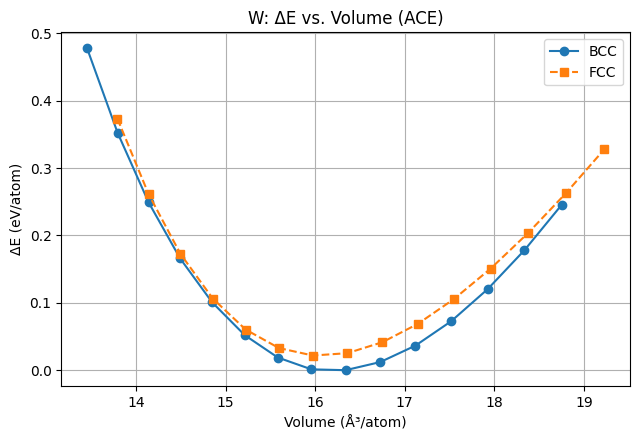


Loading model: /content/drive/MyDrive/Colab_files/Thesis/ACE/fit ACE model/saved models/Chapter5/trained on RVD dataset/m2_delta0.4_88strs/RRQR solver/W_random_disp_aug_of_evwindowbccfcc_m2_delta0.4&of_relaxedvacancy250_withoutLatt3.188_88strs_order3_totaldegree6_rcut7.5.json
Saved ΔE–V data to DeltaE_V_W_W_random_disp_aug_of_evwindowbccfcc_m2_delta0.4&of_relaxedvacancy250_withoutLatt3.188_88strs_order3_totaldegree6_rcut7.5.csv


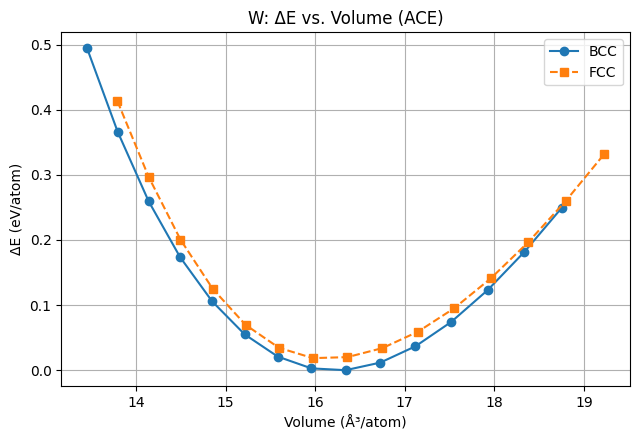


Loading model: /content/drive/MyDrive/Colab_files/Thesis/ACE/fit ACE model/saved models/Chapter5/trained on RVD dataset/m2_delta0.4_88strs/RRQR solver/W_random_disp_aug_of_evwindowbccfcc_m2_delta0.4&of_relaxedvacancy250_withoutLatt3.188_88strs_order3_totaldegree6_rcut10.5.json
Saved ΔE–V data to DeltaE_V_W_W_random_disp_aug_of_evwindowbccfcc_m2_delta0.4&of_relaxedvacancy250_withoutLatt3.188_88strs_order3_totaldegree6_rcut10.5.csv


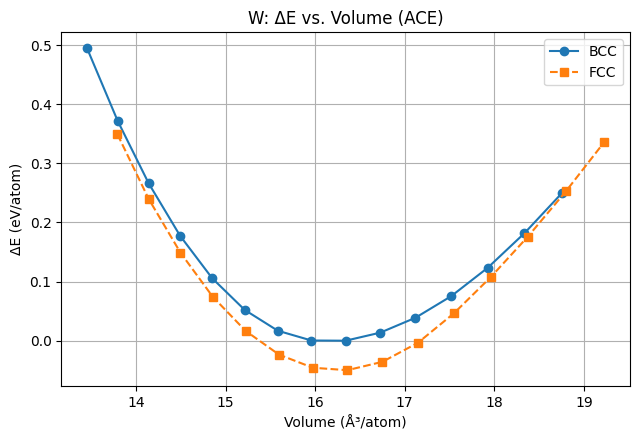


Loading model: /content/drive/MyDrive/Colab_files/Thesis/ACE/fit ACE model/saved models/Chapter5/trained on RVD dataset/m2_delta0.4_88strs/RRQR solver/W_random_disp_aug_of_evwindowbccfcc_m2_delta0.4&of_relaxedvacancy250_withoutLatt3.188_88strs_order3_totaldegree9_rcut4.5.json
Saved ΔE–V data to DeltaE_V_W_W_random_disp_aug_of_evwindowbccfcc_m2_delta0.4&of_relaxedvacancy250_withoutLatt3.188_88strs_order3_totaldegree9_rcut4.5.csv


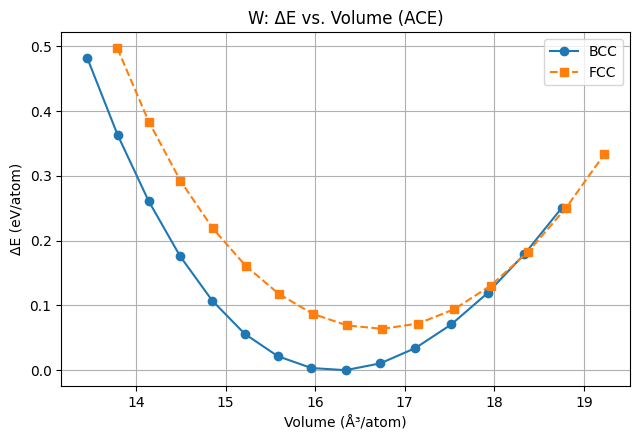


Loading model: /content/drive/MyDrive/Colab_files/Thesis/ACE/fit ACE model/saved models/Chapter5/trained on RVD dataset/m2_delta0.4_88strs/RRQR solver/W_random_disp_aug_of_evwindowbccfcc_m2_delta0.4&of_relaxedvacancy250_withoutLatt3.188_88strs_order3_totaldegree9_rcut7.5.json
Saved ΔE–V data to DeltaE_V_W_W_random_disp_aug_of_evwindowbccfcc_m2_delta0.4&of_relaxedvacancy250_withoutLatt3.188_88strs_order3_totaldegree9_rcut7.5.csv


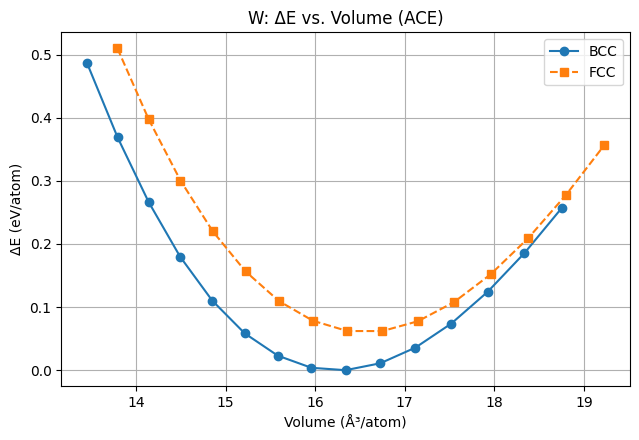


Loading model: /content/drive/MyDrive/Colab_files/Thesis/ACE/fit ACE model/saved models/Chapter5/trained on RVD dataset/m2_delta0.4_88strs/RRQR solver/W_random_disp_aug_of_evwindowbccfcc_m2_delta0.4&of_relaxedvacancy250_withoutLatt3.188_88strs_order3_totaldegree9_rcut10.5.json
Saved ΔE–V data to DeltaE_V_W_W_random_disp_aug_of_evwindowbccfcc_m2_delta0.4&of_relaxedvacancy250_withoutLatt3.188_88strs_order3_totaldegree9_rcut10.5.csv


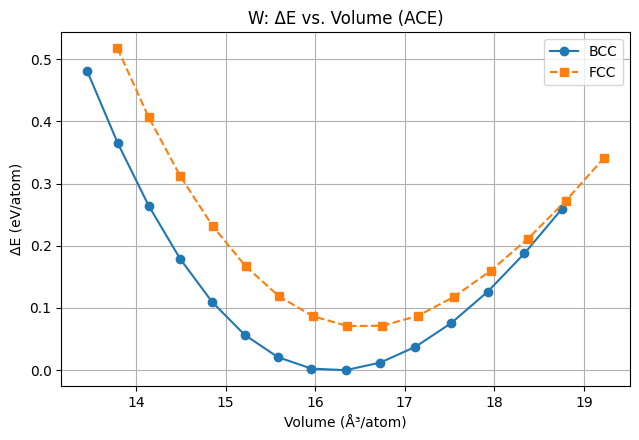


Loading model: /content/drive/MyDrive/Colab_files/Thesis/ACE/fit ACE model/saved models/Chapter5/trained on RVD dataset/m2_delta0.4_88strs/RRQR solver/W_random_disp_aug_of_evwindowbccfcc_m2_delta0.4&of_relaxedvacancy250_withoutLatt3.188_88strs_order3_totaldegree12_rcut4.5.json
Saved ΔE–V data to DeltaE_V_W_W_random_disp_aug_of_evwindowbccfcc_m2_delta0.4&of_relaxedvacancy250_withoutLatt3.188_88strs_order3_totaldegree12_rcut4.5.csv


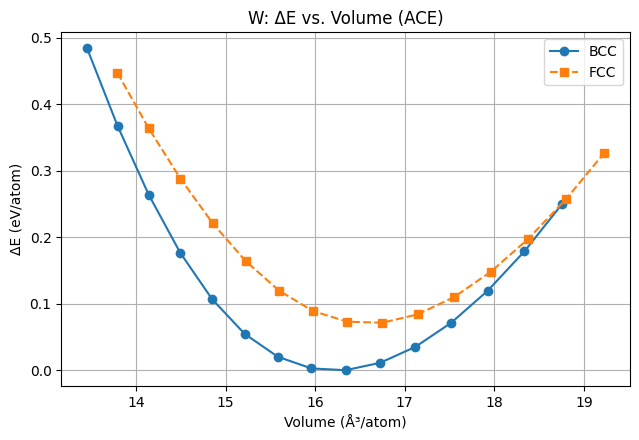


Loading model: /content/drive/MyDrive/Colab_files/Thesis/ACE/fit ACE model/saved models/Chapter5/trained on RVD dataset/m2_delta0.4_88strs/RRQR solver/W_random_disp_aug_of_evwindowbccfcc_m2_delta0.4&of_relaxedvacancy250_withoutLatt3.188_88strs_order3_totaldegree12_rcut7.5.json
Saved ΔE–V data to DeltaE_V_W_W_random_disp_aug_of_evwindowbccfcc_m2_delta0.4&of_relaxedvacancy250_withoutLatt3.188_88strs_order3_totaldegree12_rcut7.5.csv


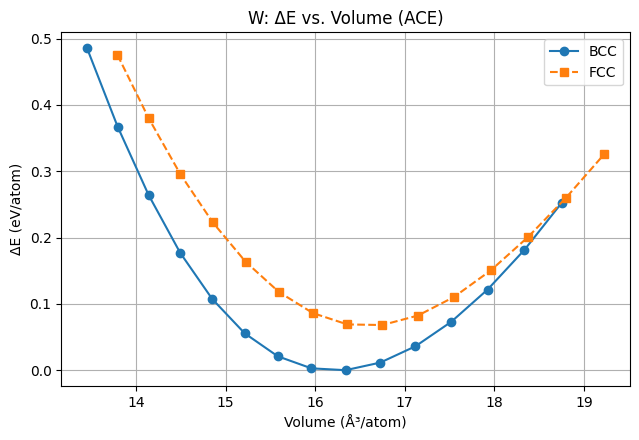


Loading model: /content/drive/MyDrive/Colab_files/Thesis/ACE/fit ACE model/saved models/Chapter5/trained on RVD dataset/m2_delta0.4_88strs/RRQR solver/W_random_disp_aug_of_evwindowbccfcc_m2_delta0.4&of_relaxedvacancy250_withoutLatt3.188_88strs_order3_totaldegree12_rcut10.5.json
Saved ΔE–V data to DeltaE_V_W_W_random_disp_aug_of_evwindowbccfcc_m2_delta0.4&of_relaxedvacancy250_withoutLatt3.188_88strs_order3_totaldegree12_rcut10.5.csv


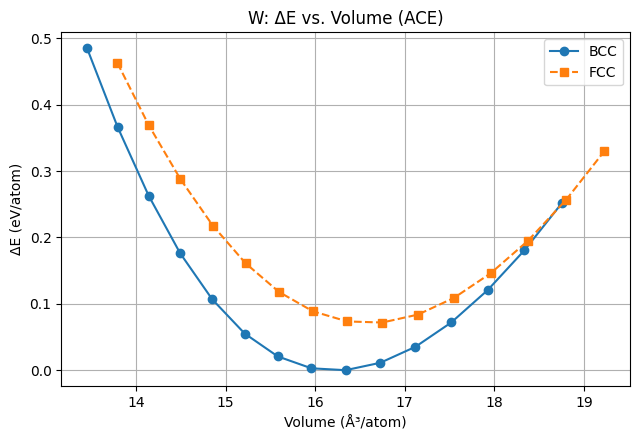


Loading model: /content/drive/MyDrive/Colab_files/Thesis/ACE/fit ACE model/saved models/Chapter5/trained on RVD dataset/m2_delta0.4_88strs/RRQR solver/W_random_disp_aug_of_evwindowbccfcc_m2_delta0.4&of_relaxedvacancy250_withoutLatt3.188_88strs_order4_totaldegree3_rcut4.5.json
Saved ΔE–V data to DeltaE_V_W_W_random_disp_aug_of_evwindowbccfcc_m2_delta0.4&of_relaxedvacancy250_withoutLatt3.188_88strs_order4_totaldegree3_rcut4.5.csv


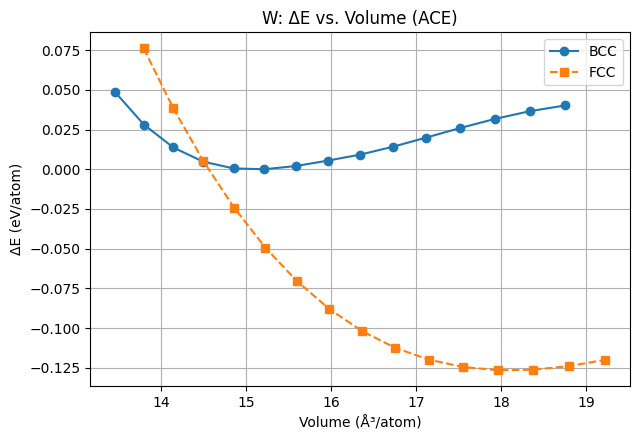


Loading model: /content/drive/MyDrive/Colab_files/Thesis/ACE/fit ACE model/saved models/Chapter5/trained on RVD dataset/m2_delta0.4_88strs/RRQR solver/W_random_disp_aug_of_evwindowbccfcc_m2_delta0.4&of_relaxedvacancy250_withoutLatt3.188_88strs_order4_totaldegree3_rcut7.5.json
Saved ΔE–V data to DeltaE_V_W_W_random_disp_aug_of_evwindowbccfcc_m2_delta0.4&of_relaxedvacancy250_withoutLatt3.188_88strs_order4_totaldegree3_rcut7.5.csv


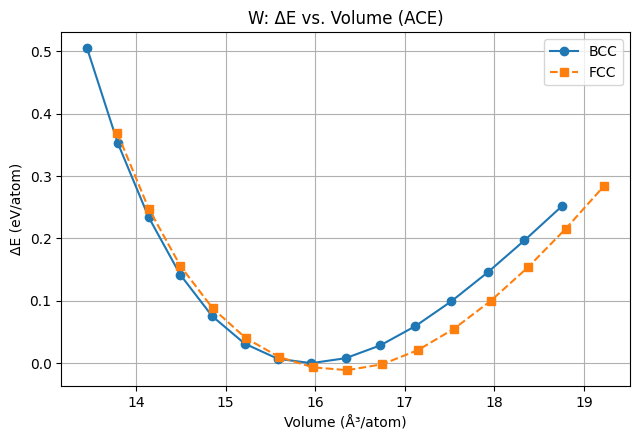


Loading model: /content/drive/MyDrive/Colab_files/Thesis/ACE/fit ACE model/saved models/Chapter5/trained on RVD dataset/m2_delta0.4_88strs/RRQR solver/W_random_disp_aug_of_evwindowbccfcc_m2_delta0.4&of_relaxedvacancy250_withoutLatt3.188_88strs_order4_totaldegree3_rcut10.5.json
Saved ΔE–V data to DeltaE_V_W_W_random_disp_aug_of_evwindowbccfcc_m2_delta0.4&of_relaxedvacancy250_withoutLatt3.188_88strs_order4_totaldegree3_rcut10.5.csv


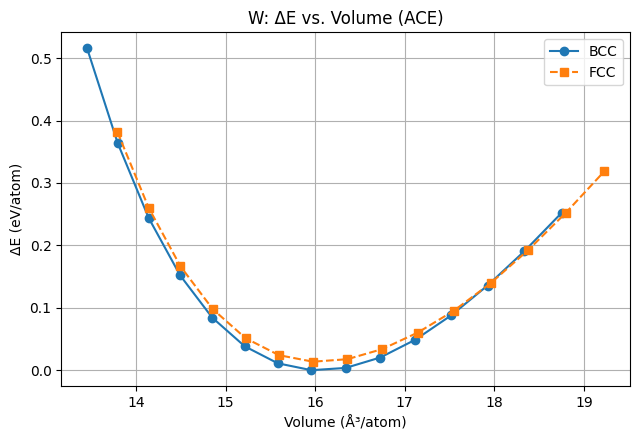


Loading model: /content/drive/MyDrive/Colab_files/Thesis/ACE/fit ACE model/saved models/Chapter5/trained on RVD dataset/m2_delta0.4_88strs/RRQR solver/W_random_disp_aug_of_evwindowbccfcc_m2_delta0.4&of_relaxedvacancy250_withoutLatt3.188_88strs_order4_totaldegree6_rcut4.5.json
Saved ΔE–V data to DeltaE_V_W_W_random_disp_aug_of_evwindowbccfcc_m2_delta0.4&of_relaxedvacancy250_withoutLatt3.188_88strs_order4_totaldegree6_rcut4.5.csv


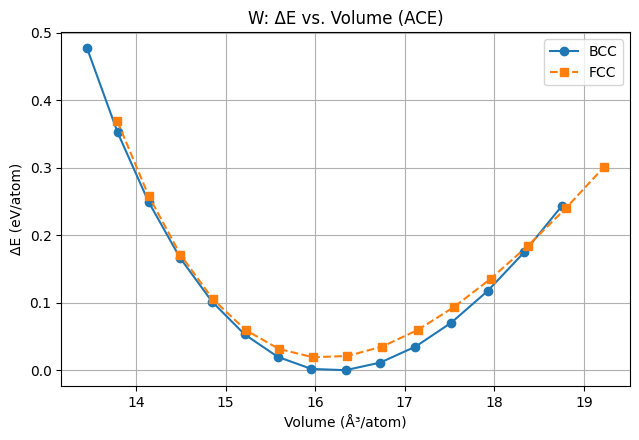


Loading model: /content/drive/MyDrive/Colab_files/Thesis/ACE/fit ACE model/saved models/Chapter5/trained on RVD dataset/m2_delta0.4_88strs/RRQR solver/W_random_disp_aug_of_evwindowbccfcc_m2_delta0.4&of_relaxedvacancy250_withoutLatt3.188_88strs_order4_totaldegree6_rcut7.5.json
Saved ΔE–V data to DeltaE_V_W_W_random_disp_aug_of_evwindowbccfcc_m2_delta0.4&of_relaxedvacancy250_withoutLatt3.188_88strs_order4_totaldegree6_rcut7.5.csv


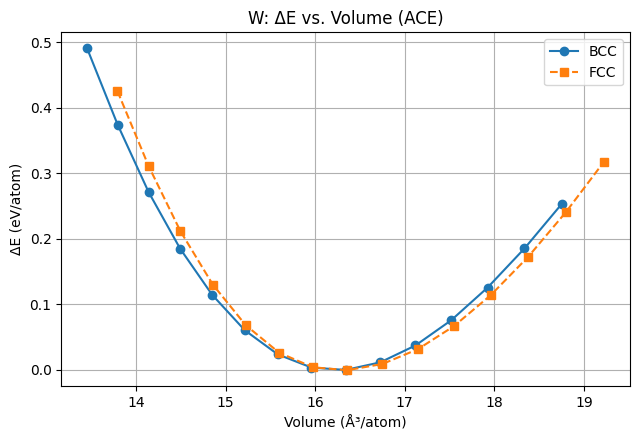


Loading model: /content/drive/MyDrive/Colab_files/Thesis/ACE/fit ACE model/saved models/Chapter5/trained on RVD dataset/m2_delta0.4_88strs/RRQR solver/W_random_disp_aug_of_evwindowbccfcc_m2_delta0.4&of_relaxedvacancy250_withoutLatt3.188_88strs_order4_totaldegree6_rcut10.5.json
Saved ΔE–V data to DeltaE_V_W_W_random_disp_aug_of_evwindowbccfcc_m2_delta0.4&of_relaxedvacancy250_withoutLatt3.188_88strs_order4_totaldegree6_rcut10.5.csv


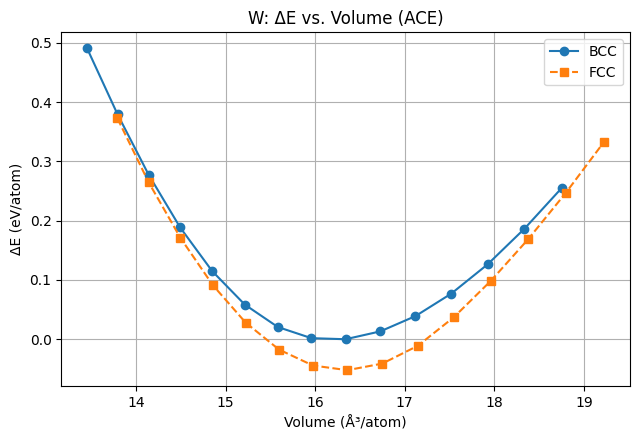


Loading model: /content/drive/MyDrive/Colab_files/Thesis/ACE/fit ACE model/saved models/Chapter5/trained on RVD dataset/m2_delta0.4_88strs/RRQR solver/W_random_disp_aug_of_evwindowbccfcc_m2_delta0.4&of_relaxedvacancy250_withoutLatt3.188_88strs_order4_totaldegree9_rcut4.5.json
Saved ΔE–V data to DeltaE_V_W_W_random_disp_aug_of_evwindowbccfcc_m2_delta0.4&of_relaxedvacancy250_withoutLatt3.188_88strs_order4_totaldegree9_rcut4.5.csv


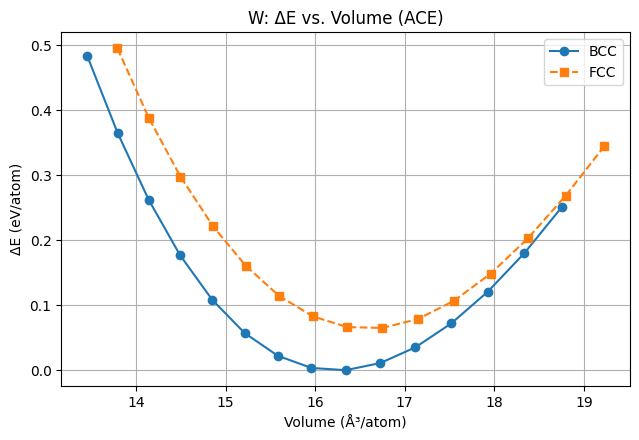


Loading model: /content/drive/MyDrive/Colab_files/Thesis/ACE/fit ACE model/saved models/Chapter5/trained on RVD dataset/m2_delta0.4_88strs/RRQR solver/W_random_disp_aug_of_evwindowbccfcc_m2_delta0.4&of_relaxedvacancy250_withoutLatt3.188_88strs_order4_totaldegree9_rcut7.5.json
Saved ΔE–V data to DeltaE_V_W_W_random_disp_aug_of_evwindowbccfcc_m2_delta0.4&of_relaxedvacancy250_withoutLatt3.188_88strs_order4_totaldegree9_rcut7.5.csv


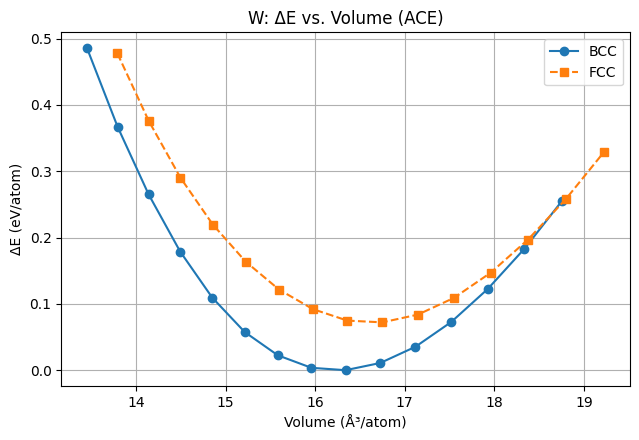


Loading model: /content/drive/MyDrive/Colab_files/Thesis/ACE/fit ACE model/saved models/Chapter5/trained on RVD dataset/m2_delta0.4_88strs/RRQR solver/W_random_disp_aug_of_evwindowbccfcc_m2_delta0.4&of_relaxedvacancy250_withoutLatt3.188_88strs_order4_totaldegree9_rcut10.5.json
Saved ΔE–V data to DeltaE_V_W_W_random_disp_aug_of_evwindowbccfcc_m2_delta0.4&of_relaxedvacancy250_withoutLatt3.188_88strs_order4_totaldegree9_rcut10.5.csv


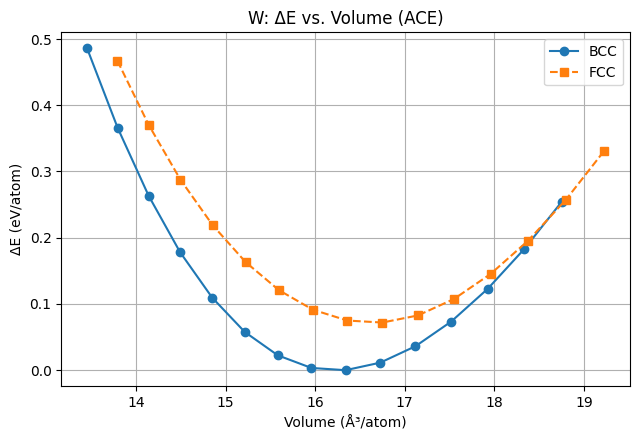


Loading model: /content/drive/MyDrive/Colab_files/Thesis/ACE/fit ACE model/saved models/Chapter5/trained on RVD dataset/m2_delta0.4_88strs/RRQR solver/W_random_disp_aug_of_evwindowbccfcc_m2_delta0.4&of_relaxedvacancy250_withoutLatt3.188_88strs_order4_totaldegree12_rcut4.5.json
Saved ΔE–V data to DeltaE_V_W_W_random_disp_aug_of_evwindowbccfcc_m2_delta0.4&of_relaxedvacancy250_withoutLatt3.188_88strs_order4_totaldegree12_rcut4.5.csv


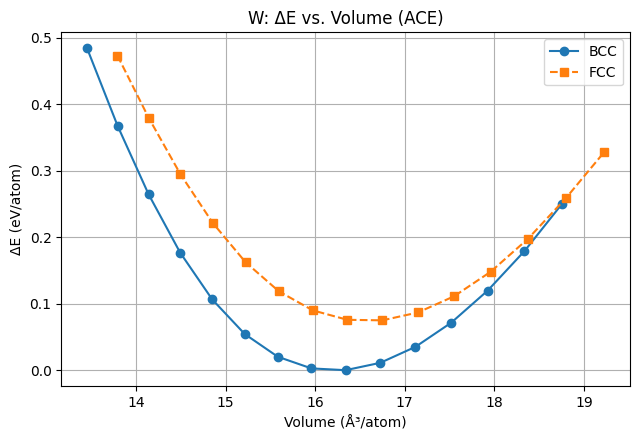


Loading model: /content/drive/MyDrive/Colab_files/Thesis/ACE/fit ACE model/saved models/Chapter5/trained on RVD dataset/m2_delta0.4_88strs/RRQR solver/W_random_disp_aug_of_evwindowbccfcc_m2_delta0.4&of_relaxedvacancy250_withoutLatt3.188_88strs_order4_totaldegree12_rcut7.5.json
Saved ΔE–V data to DeltaE_V_W_W_random_disp_aug_of_evwindowbccfcc_m2_delta0.4&of_relaxedvacancy250_withoutLatt3.188_88strs_order4_totaldegree12_rcut7.5.csv


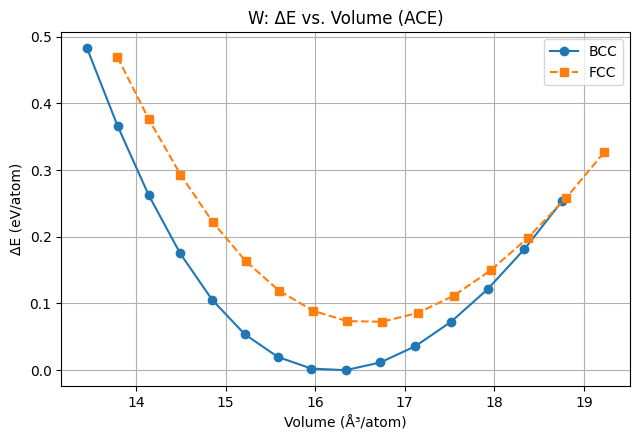


Loading model: /content/drive/MyDrive/Colab_files/Thesis/ACE/fit ACE model/saved models/Chapter5/trained on RVD dataset/m2_delta0.4_88strs/RRQR solver/W_random_disp_aug_of_evwindowbccfcc_m2_delta0.4&of_relaxedvacancy250_withoutLatt3.188_88strs_order4_totaldegree12_rcut10.5.json
Saved ΔE–V data to DeltaE_V_W_W_random_disp_aug_of_evwindowbccfcc_m2_delta0.4&of_relaxedvacancy250_withoutLatt3.188_88strs_order4_totaldegree12_rcut10.5.csv


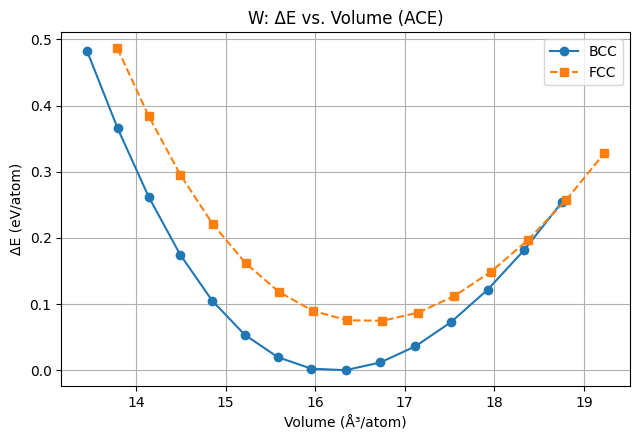


Loading model: /content/drive/MyDrive/Colab_files/Thesis/ACE/fit ACE model/saved models/Chapter5/trained on RVD dataset/m2_delta0.4_88strs/RRQR solver/W_random_disp_aug_of_evwindowbccfcc_m2_delta0.4&of_relaxedvacancy250_withoutLatt3.188_88strs_order5_totaldegree3_rcut4.5.json
Saved ΔE–V data to DeltaE_V_W_W_random_disp_aug_of_evwindowbccfcc_m2_delta0.4&of_relaxedvacancy250_withoutLatt3.188_88strs_order5_totaldegree3_rcut4.5.csv


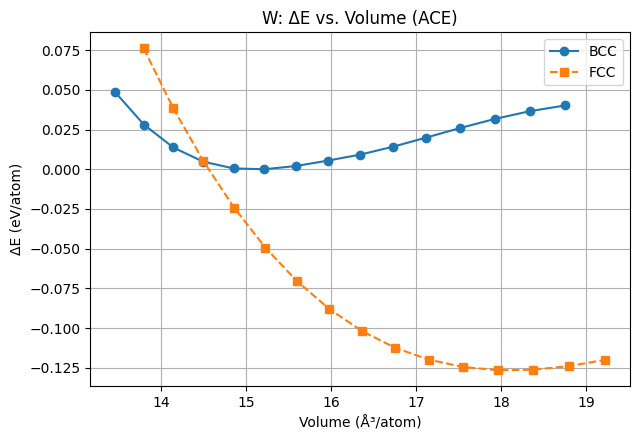


Loading model: /content/drive/MyDrive/Colab_files/Thesis/ACE/fit ACE model/saved models/Chapter5/trained on RVD dataset/m2_delta0.4_88strs/RRQR solver/W_random_disp_aug_of_evwindowbccfcc_m2_delta0.4&of_relaxedvacancy250_withoutLatt3.188_88strs_order5_totaldegree3_rcut7.5.json
Saved ΔE–V data to DeltaE_V_W_W_random_disp_aug_of_evwindowbccfcc_m2_delta0.4&of_relaxedvacancy250_withoutLatt3.188_88strs_order5_totaldegree3_rcut7.5.csv


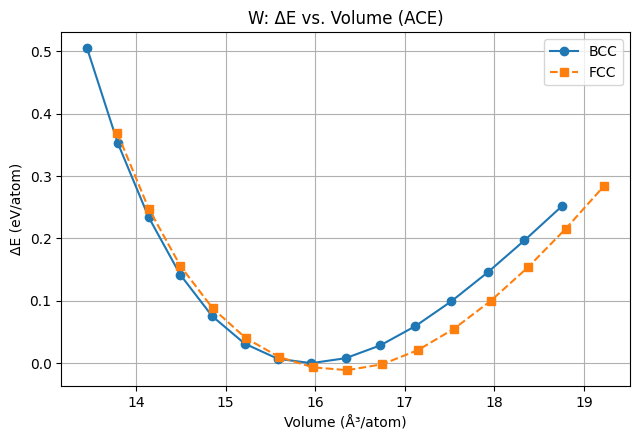


Loading model: /content/drive/MyDrive/Colab_files/Thesis/ACE/fit ACE model/saved models/Chapter5/trained on RVD dataset/m2_delta0.4_88strs/RRQR solver/W_random_disp_aug_of_evwindowbccfcc_m2_delta0.4&of_relaxedvacancy250_withoutLatt3.188_88strs_order5_totaldegree3_rcut10.5.json
Saved ΔE–V data to DeltaE_V_W_W_random_disp_aug_of_evwindowbccfcc_m2_delta0.4&of_relaxedvacancy250_withoutLatt3.188_88strs_order5_totaldegree3_rcut10.5.csv


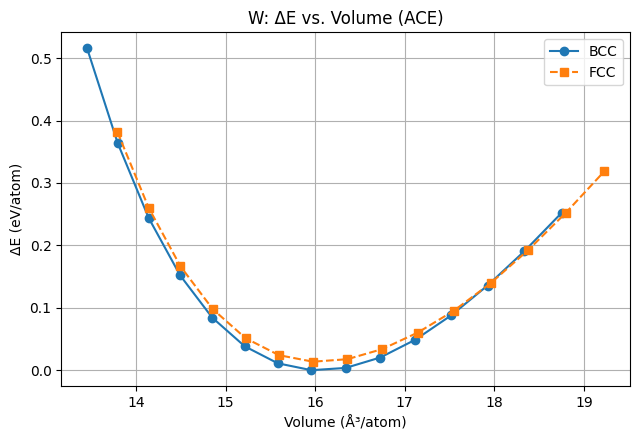


Loading model: /content/drive/MyDrive/Colab_files/Thesis/ACE/fit ACE model/saved models/Chapter5/trained on RVD dataset/m2_delta0.4_88strs/RRQR solver/W_random_disp_aug_of_evwindowbccfcc_m2_delta0.4&of_relaxedvacancy250_withoutLatt3.188_88strs_order5_totaldegree6_rcut4.5.json
Saved ΔE–V data to DeltaE_V_W_W_random_disp_aug_of_evwindowbccfcc_m2_delta0.4&of_relaxedvacancy250_withoutLatt3.188_88strs_order5_totaldegree6_rcut4.5.csv


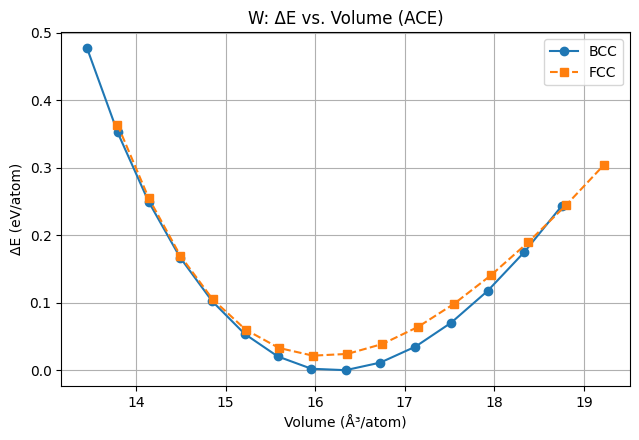


Loading model: /content/drive/MyDrive/Colab_files/Thesis/ACE/fit ACE model/saved models/Chapter5/trained on RVD dataset/m2_delta0.4_88strs/RRQR solver/W_random_disp_aug_of_evwindowbccfcc_m2_delta0.4&of_relaxedvacancy250_withoutLatt3.188_88strs_order5_totaldegree6_rcut7.5.json
Saved ΔE–V data to DeltaE_V_W_W_random_disp_aug_of_evwindowbccfcc_m2_delta0.4&of_relaxedvacancy250_withoutLatt3.188_88strs_order5_totaldegree6_rcut7.5.csv


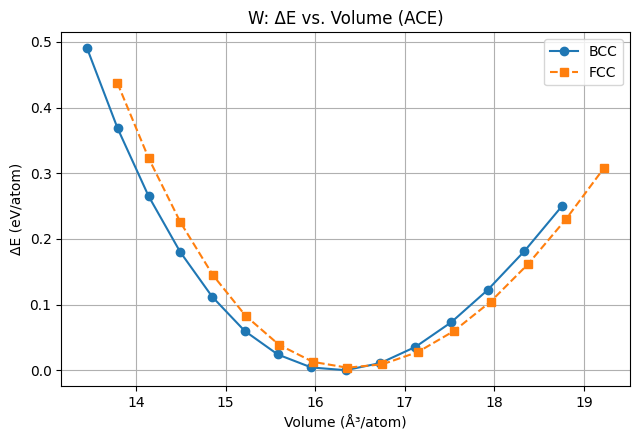


Loading model: /content/drive/MyDrive/Colab_files/Thesis/ACE/fit ACE model/saved models/Chapter5/trained on RVD dataset/m2_delta0.4_88strs/RRQR solver/W_random_disp_aug_of_evwindowbccfcc_m2_delta0.4&of_relaxedvacancy250_withoutLatt3.188_88strs_order5_totaldegree6_rcut10.5.json
Saved ΔE–V data to DeltaE_V_W_W_random_disp_aug_of_evwindowbccfcc_m2_delta0.4&of_relaxedvacancy250_withoutLatt3.188_88strs_order5_totaldegree6_rcut10.5.csv


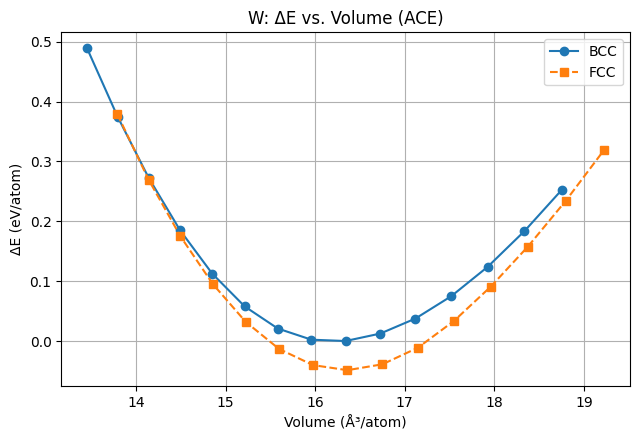


Loading model: /content/drive/MyDrive/Colab_files/Thesis/ACE/fit ACE model/saved models/Chapter5/trained on RVD dataset/m2_delta0.4_88strs/RRQR solver/W_random_disp_aug_of_evwindowbccfcc_m2_delta0.4&of_relaxedvacancy250_withoutLatt3.188_88strs_order5_totaldegree9_rcut4.5.json
Saved ΔE–V data to DeltaE_V_W_W_random_disp_aug_of_evwindowbccfcc_m2_delta0.4&of_relaxedvacancy250_withoutLatt3.188_88strs_order5_totaldegree9_rcut4.5.csv


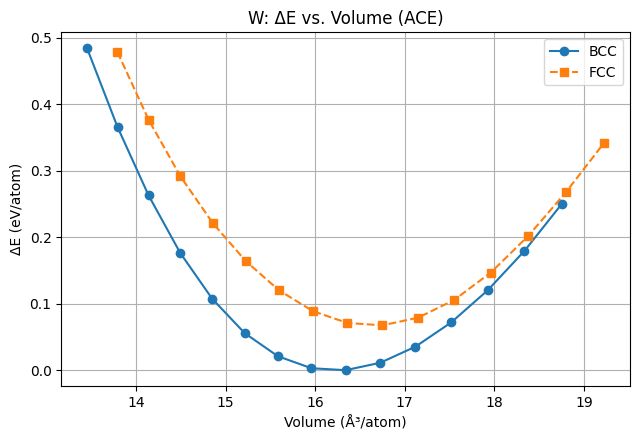


Loading model: /content/drive/MyDrive/Colab_files/Thesis/ACE/fit ACE model/saved models/Chapter5/trained on RVD dataset/m2_delta0.4_88strs/RRQR solver/W_random_disp_aug_of_evwindowbccfcc_m2_delta0.4&of_relaxedvacancy250_withoutLatt3.188_88strs_order5_totaldegree9_rcut7.5.json
Saved ΔE–V data to DeltaE_V_W_W_random_disp_aug_of_evwindowbccfcc_m2_delta0.4&of_relaxedvacancy250_withoutLatt3.188_88strs_order5_totaldegree9_rcut7.5.csv


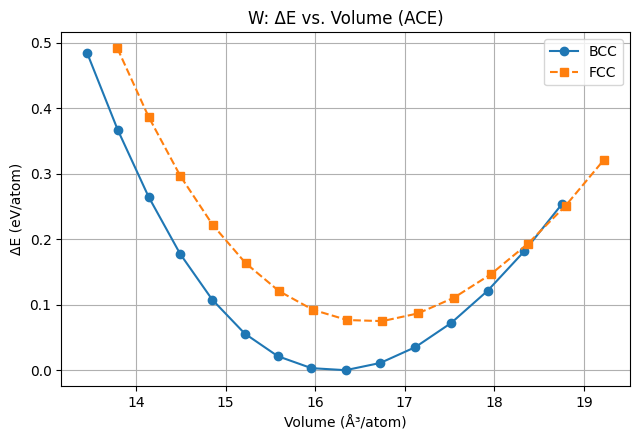


Loading model: /content/drive/MyDrive/Colab_files/Thesis/ACE/fit ACE model/saved models/Chapter5/trained on RVD dataset/m2_delta0.4_88strs/RRQR solver/W_random_disp_aug_of_evwindowbccfcc_m2_delta0.4&of_relaxedvacancy250_withoutLatt3.188_88strs_order5_totaldegree9_rcut10.5.json
Saved ΔE–V data to DeltaE_V_W_W_random_disp_aug_of_evwindowbccfcc_m2_delta0.4&of_relaxedvacancy250_withoutLatt3.188_88strs_order5_totaldegree9_rcut10.5.csv


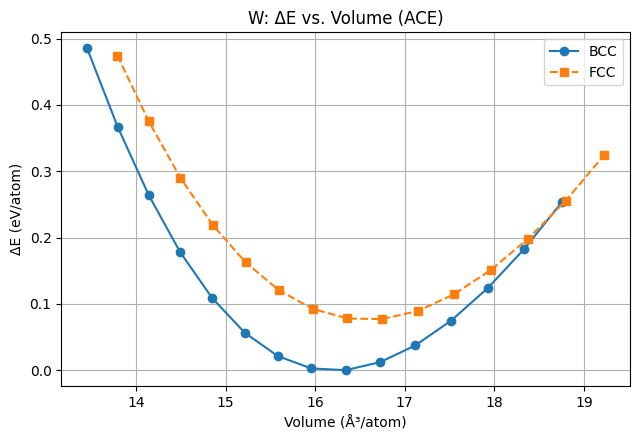


Loading model: /content/drive/MyDrive/Colab_files/Thesis/ACE/fit ACE model/saved models/Chapter5/trained on RVD dataset/m2_delta0.4_88strs/RRQR solver/W_random_disp_aug_of_evwindowbccfcc_m2_delta0.4&of_relaxedvacancy250_withoutLatt3.188_88strs_order5_totaldegree12_rcut4.5.json
Saved ΔE–V data to DeltaE_V_W_W_random_disp_aug_of_evwindowbccfcc_m2_delta0.4&of_relaxedvacancy250_withoutLatt3.188_88strs_order5_totaldegree12_rcut4.5.csv


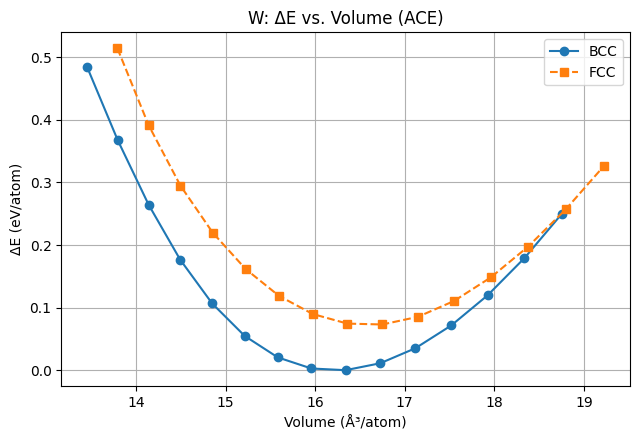


Loading model: /content/drive/MyDrive/Colab_files/Thesis/ACE/fit ACE model/saved models/Chapter5/trained on RVD dataset/m2_delta0.4_88strs/RRQR solver/W_random_disp_aug_of_evwindowbccfcc_m2_delta0.4&of_relaxedvacancy250_withoutLatt3.188_88strs_order5_totaldegree12_rcut7.5.json
Saved ΔE–V data to DeltaE_V_W_W_random_disp_aug_of_evwindowbccfcc_m2_delta0.4&of_relaxedvacancy250_withoutLatt3.188_88strs_order5_totaldegree12_rcut7.5.csv


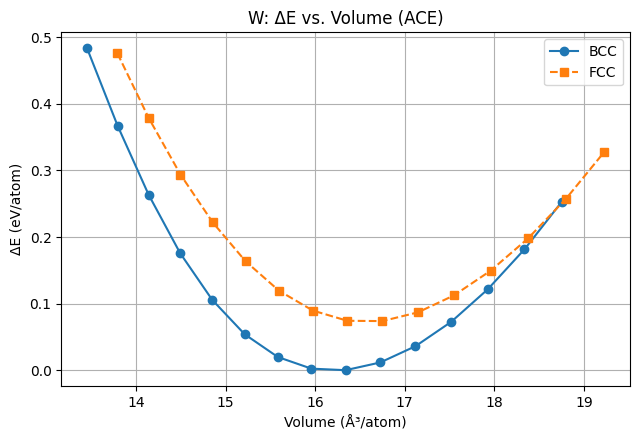


Loading model: /content/drive/MyDrive/Colab_files/Thesis/ACE/fit ACE model/saved models/Chapter5/trained on RVD dataset/m2_delta0.4_88strs/RRQR solver/W_random_disp_aug_of_evwindowbccfcc_m2_delta0.4&of_relaxedvacancy250_withoutLatt3.188_88strs_order5_totaldegree12_rcut10.5.json
Saved ΔE–V data to DeltaE_V_W_W_random_disp_aug_of_evwindowbccfcc_m2_delta0.4&of_relaxedvacancy250_withoutLatt3.188_88strs_order5_totaldegree12_rcut10.5.csv


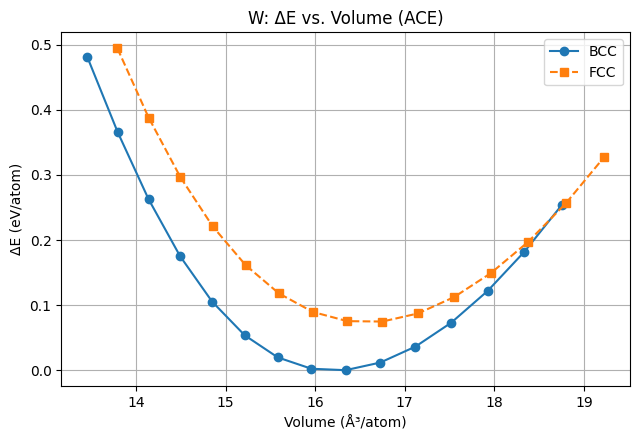


Loading model: /content/drive/MyDrive/Colab_files/Thesis/ACE/fit ACE model/saved models/Chapter5/trained on RVD dataset/m2_delta0.4_88strs/RRQR solver/W_random_disp_aug_of_evwindowbccfcc_m2_delta0.4&of_relaxedvacancy250_withoutLatt3.188_88strs_order6_totaldegree3_rcut4.5.json
Saved ΔE–V data to DeltaE_V_W_W_random_disp_aug_of_evwindowbccfcc_m2_delta0.4&of_relaxedvacancy250_withoutLatt3.188_88strs_order6_totaldegree3_rcut4.5.csv


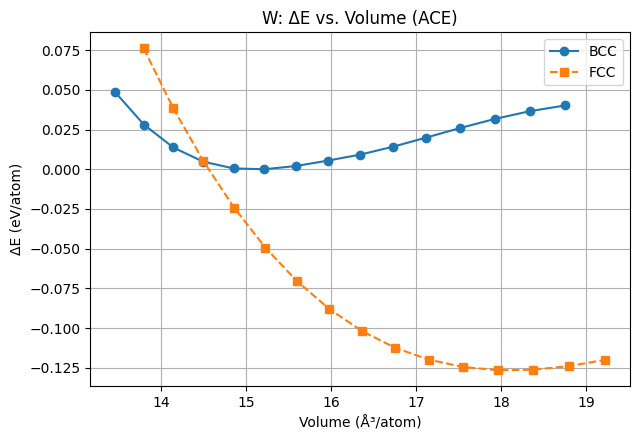


Loading model: /content/drive/MyDrive/Colab_files/Thesis/ACE/fit ACE model/saved models/Chapter5/trained on RVD dataset/m2_delta0.4_88strs/RRQR solver/W_random_disp_aug_of_evwindowbccfcc_m2_delta0.4&of_relaxedvacancy250_withoutLatt3.188_88strs_order6_totaldegree3_rcut7.5.json
Saved ΔE–V data to DeltaE_V_W_W_random_disp_aug_of_evwindowbccfcc_m2_delta0.4&of_relaxedvacancy250_withoutLatt3.188_88strs_order6_totaldegree3_rcut7.5.csv


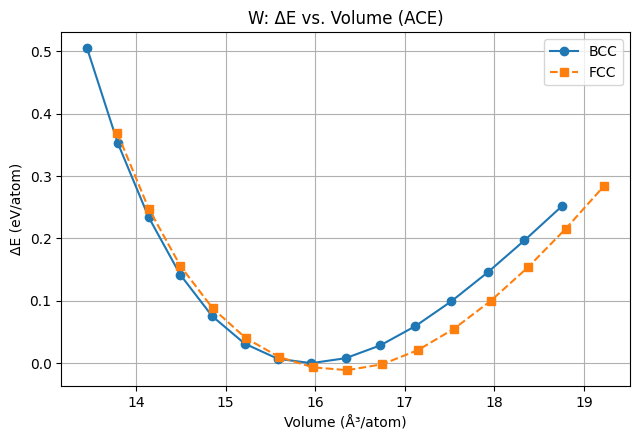


Loading model: /content/drive/MyDrive/Colab_files/Thesis/ACE/fit ACE model/saved models/Chapter5/trained on RVD dataset/m2_delta0.4_88strs/RRQR solver/W_random_disp_aug_of_evwindowbccfcc_m2_delta0.4&of_relaxedvacancy250_withoutLatt3.188_88strs_order6_totaldegree3_rcut10.5.json
Saved ΔE–V data to DeltaE_V_W_W_random_disp_aug_of_evwindowbccfcc_m2_delta0.4&of_relaxedvacancy250_withoutLatt3.188_88strs_order6_totaldegree3_rcut10.5.csv


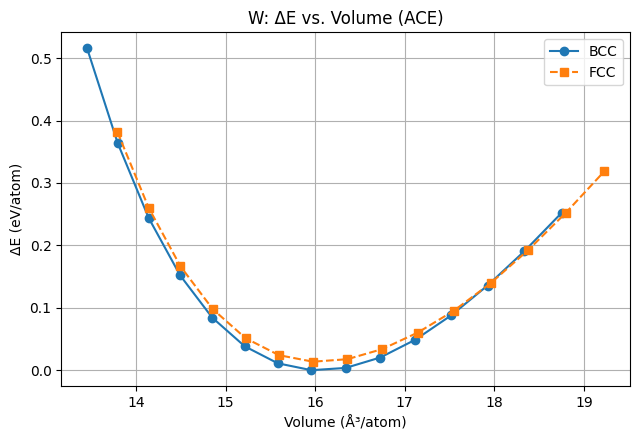


Loading model: /content/drive/MyDrive/Colab_files/Thesis/ACE/fit ACE model/saved models/Chapter5/trained on RVD dataset/m2_delta0.4_88strs/RRQR solver/W_random_disp_aug_of_evwindowbccfcc_m2_delta0.4&of_relaxedvacancy250_withoutLatt3.188_88strs_order6_totaldegree6_rcut4.5.json
Saved ΔE–V data to DeltaE_V_W_W_random_disp_aug_of_evwindowbccfcc_m2_delta0.4&of_relaxedvacancy250_withoutLatt3.188_88strs_order6_totaldegree6_rcut4.5.csv


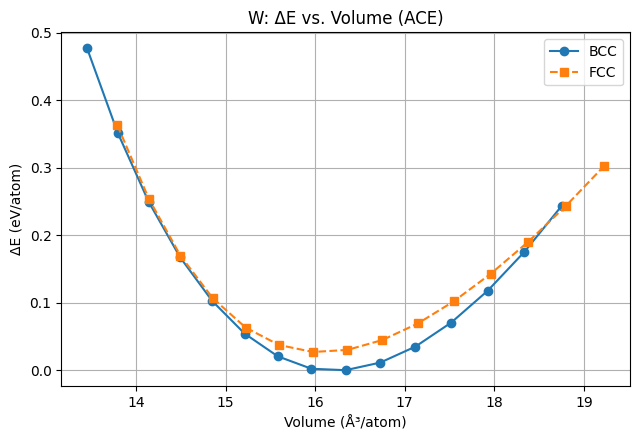


Loading model: /content/drive/MyDrive/Colab_files/Thesis/ACE/fit ACE model/saved models/Chapter5/trained on RVD dataset/m2_delta0.4_88strs/RRQR solver/W_random_disp_aug_of_evwindowbccfcc_m2_delta0.4&of_relaxedvacancy250_withoutLatt3.188_88strs_order6_totaldegree6_rcut7.5.json
Saved ΔE–V data to DeltaE_V_W_W_random_disp_aug_of_evwindowbccfcc_m2_delta0.4&of_relaxedvacancy250_withoutLatt3.188_88strs_order6_totaldegree6_rcut7.5.csv


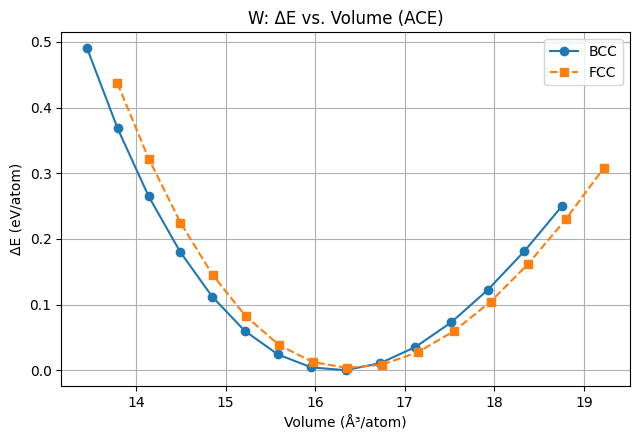


Loading model: /content/drive/MyDrive/Colab_files/Thesis/ACE/fit ACE model/saved models/Chapter5/trained on RVD dataset/m2_delta0.4_88strs/RRQR solver/W_random_disp_aug_of_evwindowbccfcc_m2_delta0.4&of_relaxedvacancy250_withoutLatt3.188_88strs_order6_totaldegree6_rcut10.5.json
Saved ΔE–V data to DeltaE_V_W_W_random_disp_aug_of_evwindowbccfcc_m2_delta0.4&of_relaxedvacancy250_withoutLatt3.188_88strs_order6_totaldegree6_rcut10.5.csv


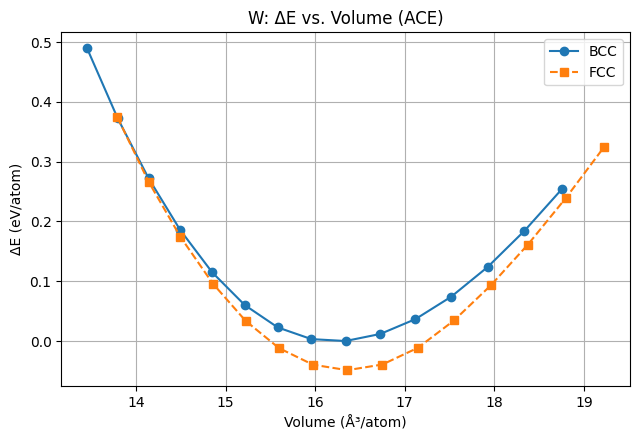


Loading model: /content/drive/MyDrive/Colab_files/Thesis/ACE/fit ACE model/saved models/Chapter5/trained on RVD dataset/m2_delta0.4_88strs/RRQR solver/W_random_disp_aug_of_evwindowbccfcc_m2_delta0.4&of_relaxedvacancy250_withoutLatt3.188_88strs_order6_totaldegree9_rcut4.5.json
Saved ΔE–V data to DeltaE_V_W_W_random_disp_aug_of_evwindowbccfcc_m2_delta0.4&of_relaxedvacancy250_withoutLatt3.188_88strs_order6_totaldegree9_rcut4.5.csv


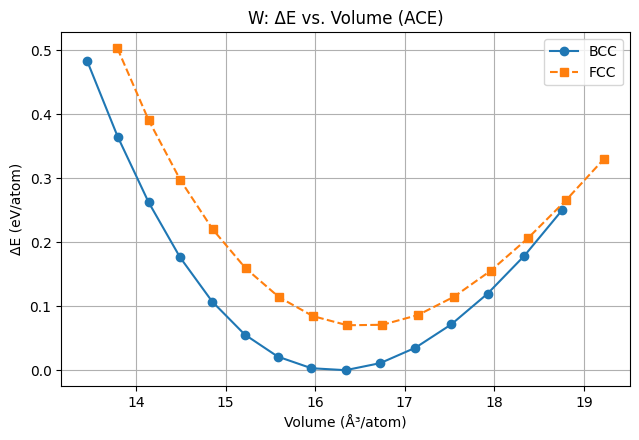


Loading model: /content/drive/MyDrive/Colab_files/Thesis/ACE/fit ACE model/saved models/Chapter5/trained on RVD dataset/m2_delta0.4_88strs/RRQR solver/W_random_disp_aug_of_evwindowbccfcc_m2_delta0.4&of_relaxedvacancy250_withoutLatt3.188_88strs_order6_totaldegree9_rcut7.5.json
Saved ΔE–V data to DeltaE_V_W_W_random_disp_aug_of_evwindowbccfcc_m2_delta0.4&of_relaxedvacancy250_withoutLatt3.188_88strs_order6_totaldegree9_rcut7.5.csv


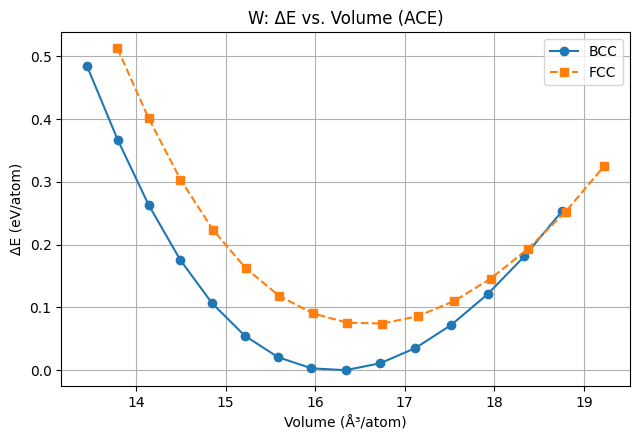


Loading model: /content/drive/MyDrive/Colab_files/Thesis/ACE/fit ACE model/saved models/Chapter5/trained on RVD dataset/m2_delta0.4_88strs/RRQR solver/W_random_disp_aug_of_evwindowbccfcc_m2_delta0.4&of_relaxedvacancy250_withoutLatt3.188_88strs_order6_totaldegree9_rcut10.5.json
Saved ΔE–V data to DeltaE_V_W_W_random_disp_aug_of_evwindowbccfcc_m2_delta0.4&of_relaxedvacancy250_withoutLatt3.188_88strs_order6_totaldegree9_rcut10.5.csv


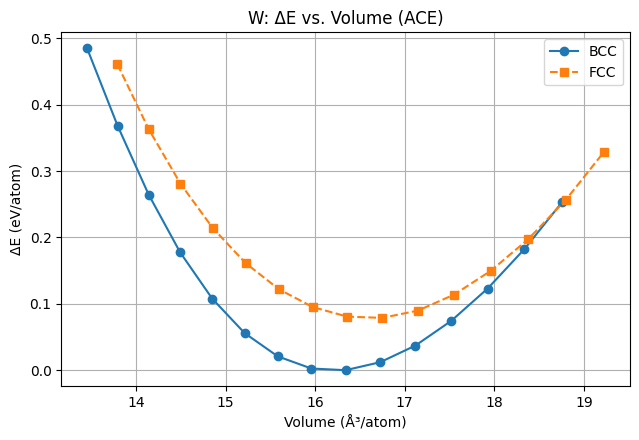


Loading model: /content/drive/MyDrive/Colab_files/Thesis/ACE/fit ACE model/saved models/Chapter5/trained on RVD dataset/m2_delta0.4_88strs/RRQR solver/W_random_disp_aug_of_evwindowbccfcc_m2_delta0.4&of_relaxedvacancy250_withoutLatt3.188_88strs_order6_totaldegree12_rcut4.5.json
Saved ΔE–V data to DeltaE_V_W_W_random_disp_aug_of_evwindowbccfcc_m2_delta0.4&of_relaxedvacancy250_withoutLatt3.188_88strs_order6_totaldegree12_rcut4.5.csv


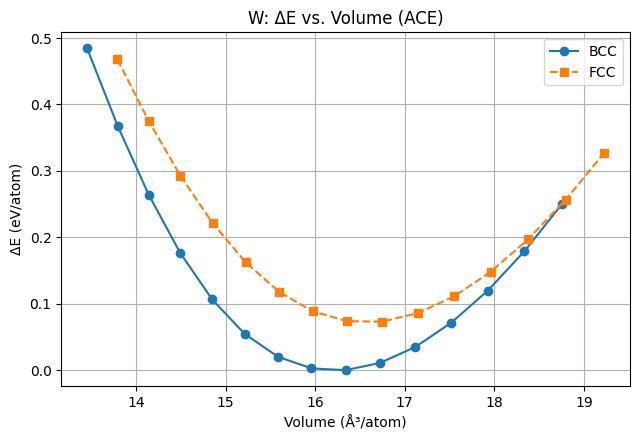


Loading model: /content/drive/MyDrive/Colab_files/Thesis/ACE/fit ACE model/saved models/Chapter5/trained on RVD dataset/m2_delta0.4_88strs/RRQR solver/W_random_disp_aug_of_evwindowbccfcc_m2_delta0.4&of_relaxedvacancy250_withoutLatt3.188_88strs_order6_totaldegree12_rcut7.5.json
Saved ΔE–V data to DeltaE_V_W_W_random_disp_aug_of_evwindowbccfcc_m2_delta0.4&of_relaxedvacancy250_withoutLatt3.188_88strs_order6_totaldegree12_rcut7.5.csv


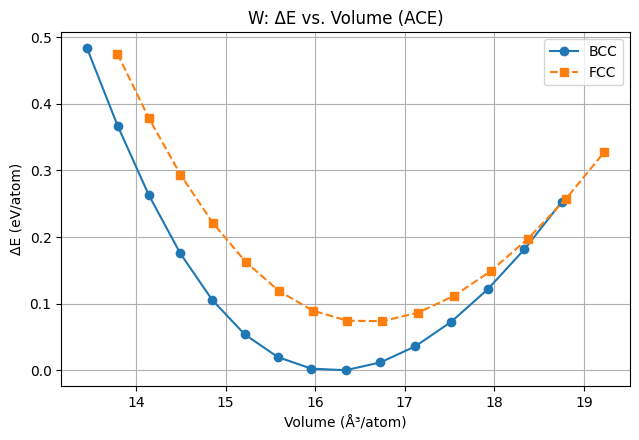


Loading model: /content/drive/MyDrive/Colab_files/Thesis/ACE/fit ACE model/saved models/Chapter5/trained on RVD dataset/m2_delta0.4_88strs/RRQR solver/W_random_disp_aug_of_evwindowbccfcc_m2_delta0.4&of_relaxedvacancy250_withoutLatt3.188_88strs_order6_totaldegree12_rcut10.5.json
Saved ΔE–V data to DeltaE_V_W_W_random_disp_aug_of_evwindowbccfcc_m2_delta0.4&of_relaxedvacancy250_withoutLatt3.188_88strs_order6_totaldegree12_rcut10.5.csv


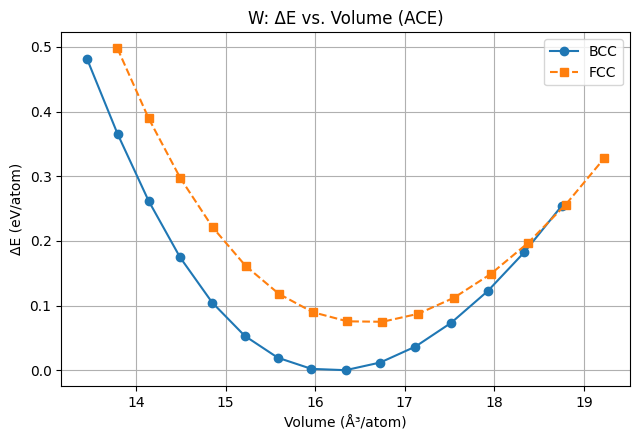

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from ase.build import bulk
import os


# -----------------------------
# SETTINGS
# -----------------------------




"""
# Uncomment for 176 strs
param_file = "fit ACE model/saved models/Chapter5/trained on RVD dataset/m2_delta0.4_176strs/RRQR solver/resultsrandom_disp_aug_of_evwindowbccfcc_m2_delta0.4&of_relaxedvacancy250_withoutLatt3.188_RRQR.csv"
model_dir  = "fit ACE model/saved models/Chapter5/trained on RVD dataset/m2_delta0.4_176strs/RRQR solver"
dataset_name = "W_random_disp_aug_of_evwindowbccfcc_m2_delta0.4&of_relaxedvacancy250_withoutLatt3.188"
output_dir   ="/ACEcalculator&MACE MP A13 benchmarks/Chapter 5/W/E-V curve/results of models on on RVD dataset/m2_delta0.4_176strs"
"""

"""
# Uncomment for 352 strs
param_file = "fit ACE model/saved models/Chapter5/trained on RVD dataset/m4_delta0.4_352strs/RRQR solver/resultsrandom_disp_aug_of_evwindowbccfcc_m4_delta0.4&of_relaxedvacancy250_withoutLatt3.188_RRQR.csv"
model_dir  = "fit ACE model/saved models/Chapter5/trained on RVD dataset/m4_delta0.4_352strs/RRQR solver"
dataset_name = "W_random_disp_aug_of_evwindowbccfcc_m4_delta0.4&of_relaxedvacancy250_withoutLatt3.188"
output_dir   ="/ACEcalculator&MACE MP A13 benchmarks/Chapter 5/W/E-V curve/results of models on on RVD dataset/m4_delta0.4_352strs"
"""

"""
# Uncomment for 88 strs
param_file = "fit ACE model/saved models/Chapter5/trained on RVD dataset/m2_delta0.4_88strs/RRQR solver/resultsrandom_disp_aug_of_evwindowbccfcc_m2_delta0.4&of_relaxedvacancy250_withoutLatt3.188_88strs_RRQR.csv"
model_dir  = "fit ACE model/saved models/Chapter5/trained on RVD dataset/m2_delta0.4_88strs/RRQR solver"
dataset_name = "W_random_disp_aug_of_evwindowbccfcc_m2_delta0.4&of_relaxedvacancy250_withoutLatt3.188_88strs"
output_dir   ="/ACEcalculator&MACE MP A13 benchmarks/Chapter 5/W/E-V curve/results of models on on RVD dataset/m2_delta0.4_88strs"
"""


# -----------------------------
# READ PARAMETER FILE
# -----------------------------
params = pd.read_csv(param_file)




# === Setup ===
element = "W"
a0_bcc = 3.188
a0_fcc = 4.05
scaling_factors = np.linspace(0.94, 1.05, 15)  # example: ±6% around a0


for _, row in params.iterrows():
    order = int(row["order"])
    totaldegree = int(row["totaldegree"])
    rcut = float(row["rcut"])

    potential_path = os.path.join(model_dir,f"{dataset_name}_order{order}_totaldegree{totaldegree}_rcut{rcut}.json")

    print(f"\nLoading model: {potential_path}")



    # Load ACE calculator
    calc = ACE1(potential_path)

    # === Energy vs Volume ===
    def compute_e_vs_v(crystal, a0):
        volumes, energies = [], []
        for scale in scaling_factors:
            atoms = bulk(element, crystal, a=a0 * scale)
            atoms.calc = calc
            E_per_atom = atoms.get_potential_energy() / len(atoms)
            V_per_atom = atoms.get_volume() / len(atoms)
            volumes.append(V_per_atom)
            energies.append(E_per_atom)
        return np.array(volumes), np.array(energies)

    # Compute curves
    vol_bcc, en_bcc = compute_e_vs_v("bcc", a0_bcc)
    vol_fcc, en_fcc = compute_e_vs_v("fcc", a0_fcc)

    # === Shift to DeltaE (relative to BCC minimum) ===
    E_ref = en_bcc.min()
    delta_en_bcc = en_bcc - E_ref
    delta_en_fcc = en_fcc - E_ref

    # === Save to CSV (name based on model) ===
    model_name = os.path.splitext(os.path.basename(potential_path))[0]
    out_csv = f"DeltaE_V_W_{model_name}.csv"

    df = pd.DataFrame({
        "V_BCC": vol_bcc,
        "DeltaE_BCC": delta_en_bcc,
        "V_FCC": vol_fcc,
        "DeltaE_FCC": delta_en_fcc
    })
    df.to_csv(os.path.join(output_dir, out_csv), index=False)
    print(f"Saved ΔE–V data to {out_csv}")

    # === Plot ===
    plt.figure(figsize=(6.5, 4.5))
    plt.plot(vol_bcc, delta_en_bcc, 'o-', label="BCC")
    plt.plot(vol_fcc, delta_en_fcc, 's--', label="FCC")
    plt.xlabel("Volume (Å³/atom)")
    plt.ylabel("ΔE (eV/atom)")
    plt.title(f"{element.upper()}: ΔE vs. Volume (ACE)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    out_png = f"DeltaE_V_W_{model_name}.png"
    plt.savefig(os.path.join(output_dir, out_png), dpi=300)
    plt.show()


#### Vacancy formation energy

In [ ]:
from ase.build import bulk
from ase.constraints import UnitCellFilter
from numpy.linalg import norm
from ase.optimize import BFGS
from ase.io import write
import numpy as np


# -----------------------------
# SETTINGS
# -----------------------------
"""
# Uncomment for 352 strs
param_file = "/fit ACE model/saved models/Chapter5/trained on RVD dataset/m4_delta0.4_352strs/RRQR solver/resultsrandom_disp_aug_of_evwindowbccfcc_m4_delta0.4&of_relaxedvacancy250_withoutLatt3.188_RRQR.csv"
model_dir  = "/fit ACE model/saved models/Chapter5/trained on RVD dataset/m4_delta0.4_352strs/RRQR solver"
dataset_name = "W_random_disp_aug_of_evwindowbccfcc_m4_delta0.4&of_relaxedvacancy250_withoutLatt3.188"
"""

"""
# Uncomment for 176 strs
param_file = "/fit ACE model/saved models/Chapter5/trained on RVD dataset/m2_delta0.4_176strs/RRQR solver/resultsrandom_disp_aug_of_evwindowbccfcc_m2_delta0.4&of_relaxedvacancy250_withoutLatt3.188_RRQR.csv"
model_dir  = "/fit ACE model/saved models/Chapter5/trained on RVD dataset/m2_delta0.4_176strs/RRQR solver"
dataset_name = "W_random_disp_aug_of_evwindowbccfcc_m2_delta0.4&of_relaxedvacancy250_withoutLatt3.188"
"""

"""
# Uncomment for 88 strs
param_file = "/fit ACE model/saved models/Chapter5/trained on RVD dataset/m2_delta0.4_88strs/RRQR solver/resultsrandom_disp_aug_of_evwindowbccfcc_m2_delta0.4&of_relaxedvacancy250_withoutLatt3.188_88strs_RRQR.csv"
model_dir  = "/fit ACE model/saved models/Chapter5/trained on RVD dataset/m2_delta0.4_88strs/RRQR solver"
dataset_name = "W_random_disp_aug_of_evwindowbccfcc_m2_delta0.4&of_relaxedvacancy250_withoutLatt3.188_88strs"
"""


out_file   = f"Vacancy_formation_energy_{dataset_name}.csv"





# -----------------------------
# READ PARAMETER FILE
# -----------------------------
params = pd.read_csv(param_file)

# -----------------------------
# RESULTS CONTAINER
# -----------------------------
results = {
    "order": [],
    "totaldegree": [],
    "rcut": [],
    "Vacancy formation energy": []
}






# === Vacancy Formation Calculation ===

# Parameters
element = "W"
a0 = 3.188
supercell_size = (5, 5, 5)
fmax_tol = 1e-1

# -----------------------------
# LOOP OVER MODELS
# -----------------------------
for _, row in params.iterrows():
    order = int(row["order"])
    totaldegree = int(row["totaldegree"])
    rcut = float(row["rcut"])

    potential_path = os.path.join(model_dir,f"{dataset_name}_order{order}_totaldegree{totaldegree}_rcut{rcut}.json")

    print(f"\nLoading model: {potential_path}")


    # --- Build and relax bulk supercell ---
    atoms_bulk = bulk(element, 'bcc', a=a0, cubic=True).repeat(supercell_size)
    N_bulk = len(atoms_bulk)

    atoms_bulk.calc = ACE1(potential_path)
    opt_bulk = BFGS(atoms_bulk, logfile=None)
    opt_bulk.run(fmax=fmax_tol)

    E_bulk = atoms_bulk.get_potential_energy()
    print(f"Bulk energy (N={N_bulk}): {E_bulk:.3f} eV")

    # --- Create and relax vacancy structure ---
    atoms_vac = atoms_bulk.copy()
    atoms_vac.pop(len(atoms_vac) // 2)
    atoms_vac.calc = ACE1(potential_path)

    opt_vac = BFGS(atoms_vac, logfile=None)
    opt_vac.run(fmax=fmax_tol, steps=10)

    E_vac = atoms_vac.get_potential_energy()

    # --- Calculate vacancy formation energy ---
    vac_E = E_vac - ((N_bulk - 1) / N_bulk) * E_bulk

    results["order"].append(order)
    results["totaldegree"].append(totaldegree)
    results["rcut"].append(rcut)
    results["Vacancy formation energy"].append(vac_E)
    print(f"Vacancy formation energy: {vac_E:.3f} eV")

# -----------------------------
# SAVE TO CSV
# -----------------------------
df_results = pd.DataFrame(results)
df_results.to_csv(os.path.join(output_dir, out_file), index=False)

print(f"\nSaved timings to {out_file}")


Loading model: /content/drive/MyDrive/Colab_files/Thesis/ACE/fit ACE model/saved models/Chapter5/trained on RVD dataset/m2_delta0.4_88strs/RRQR solver/W_random_disp_aug_of_evwindowbccfcc_m2_delta0.4&of_relaxedvacancy250_withoutLatt3.188_88strs_order3_totaldegree3_rcut4.5.json
Bulk energy (N=250): -3138.946 eV
Vacancy formation energy: -0.562 eV

Loading model: /content/drive/MyDrive/Colab_files/Thesis/ACE/fit ACE model/saved models/Chapter5/trained on RVD dataset/m2_delta0.4_88strs/RRQR solver/W_random_disp_aug_of_evwindowbccfcc_m2_delta0.4&of_relaxedvacancy250_withoutLatt3.188_88strs_order3_totaldegree3_rcut7.5.json
Bulk energy (N=250): -3181.726 eV
Vacancy formation energy: -10.971 eV

Loading model: /content/drive/MyDrive/Colab_files/Thesis/ACE/fit ACE model/saved models/Chapter5/trained on RVD dataset/m2_delta0.4_88strs/RRQR solver/W_random_disp_aug_of_evwindowbccfcc_m2_delta0.4&of_relaxedvacancy250_withoutLatt3.188_88strs_order3_totaldegree3_rcut10.5.json
Bulk energy (N=250): -31

### Mo

#### Lattice Constant

In [ ]:
from ase.build import bulk
from ase.constraints import UnitCellFilter
from numpy.linalg import norm
from ase.optimize import BFGS
from ase.io import write
import numpy as np

element_symbol = "Mo"
crystal = "bcc"
initial_lattice = 3.0
supercell = (3, 3, 3)
num_spercell_x = supercell[0]
# --- Perform structure + cell optimization ---
atoms = bulk(element_symbol, crystal, a=initial_lattice)*supercell

potential_path = "/ACEcalculator&MACE MP A13 benchmarks/Mo/Mo_Dataset_order4_totaldegree9_rcut4.5_Mo_random_disp_aug_of_evwindowbccfcc_m2_delta0.4&of_relaxedvacancy250.json"



atoms.calc = ACE1(potential_path)

ucf = UnitCellFilter(atoms, hydrostatic_strain=True)
opt = BFGS(ucf, trajectory="cell_relax.traj", logfile="cell_relax.log")
opt.run(fmax=0.01)

# --- Output relaxed cell and lattice constant ---
relaxed_cell = atoms.get_cell()

relaxed_a = atoms.get_cell()[0][0]/(num_spercell_x/2)


print("Relaxed cell:\n", relaxed_cell)
print(f"Relaxed lattice constant a = {relaxed_a:.5f} Å")

write("relaxed_cell.xyz", atoms)


/tmp/ipython-input-2826554919.py:23: FutureWarning: Import UnitCellFilter from ase.filters
  ucf = UnitCellFilter(atoms, hydrostatic_strain=True)


Relaxed cell:
 Cell([[-4.7552371171008545, 4.755237117100884, 4.755237117100879], [4.7552371171008545, -4.755237117100884, 4.755237117100829], [4.7552371171008545, 4.755237117100824, -4.755237117100879]])
Relaxed lattice constant a = -3.17016 Å


#### Cubic elastic constants

In [ ]:
import numpy as np
from ase.build import bulk
from ase.units import GPa
from copy import deepcopy
from ase.optimize import BFGS
from ase.calculators.calculator import Calculator
import os

potential_path = "/ACEcalculator&MACE MP A13 benchmarks/Mo/Mo_Dataset_order4_totaldegree9_rcut4.5_Mo_random_disp_aug_of_evwindowbccfcc_m2_delta0.4&of_relaxedvacancy250.json"



# === Julia Setup ===
from julia.api import Julia
jl = Julia(compiled_modules=False)
from julia import Main
# ---------------------------
# Setup: Load model and atoms
# ---------------------------
atoms = bulk("Mo", "bcc", a=3.170)
atoms.calc = ACE1(potential_path)

E0 = atoms.get_potential_energy()
V0 = atoms.get_volume()

# ---------------------------
# Helper Functions
# ---------------------------
def apply_strain(atoms, strain_matrix):
    strained_atoms = atoms.copy()
    cell = strained_atoms.get_cell()
    new_cell = cell @ (np.eye(3) + strain_matrix)
    strained_atoms.set_cell(new_cell, scale_atoms=True)
    strained_atoms.calc = ACE1(potential_path)  # Reassign ACE calculator
    return strained_atoms


def fit_elastic_constant(strain_list, energy_list, factor=1.0):
    x = np.array([d**2 for d in strain_list])
    y = np.array(energy_list)
    coeffs = np.polyfit(x, y, 1)
    A = coeffs[0]
    #return 2 * A / factor
    return A / factor

# ---------------------------
# C11: Uniaxial strain in xx
# ---------------------------
deltas = np.linspace(-0.005, 0.005, 10)
E_C11 = []

for delta in deltas:
    strain = np.zeros((3, 3))
    strain[0, 0] = delta
    strained = apply_strain(atoms, strain)
    E = strained.get_potential_energy()
    E_C11.append((E - E0) / V0)

C11 = fit_elastic_constant(deltas, E_C11, factor=1/2)

# ---------------------------
# C12: Orthorhombic strain
# ---------------------------
E_C12 = []

for delta in deltas:
    strain = np.zeros((3, 3))
    strain[0, 0] = delta
    strain[1, 1] = -delta
    strained = apply_strain(atoms, strain)
    E = strained.get_potential_energy()
    E_C12.append((E - E0) / V0)

C11_minus_C12 = fit_elastic_constant(deltas, E_C12, factor=1.0)
C12 = C11 - C11_minus_C12

# ---------------------------
# C44: Shear strain (xy)
# ---------------------------
E_C44 = []

for delta in deltas:
    strain = np.zeros((3, 3))
    strain[0, 1] = strain[1, 0] = delta
    strained = apply_strain(atoms, strain)
    E = strained.get_potential_energy()
    E_C44.append((E - E0) / V0)

C44 = fit_elastic_constant(deltas, E_C44, factor=2.0)

# ---------------------------
# Convert and Print
# ---------------------------
eV_per_A3_to_GPa = GPa

print("\nElastic Constants (from ACE model):")
print(f"C11 ≈ {C11 / eV_per_A3_to_GPa:.2f} GPa")
print(f"C12 ≈ {C12 / eV_per_A3_to_GPa:.2f} GPa")
print(f"C44 ≈ {C44 / eV_per_A3_to_GPa:.2f} GPa")



Elastic Constants (from ACE model):
C11 ≈ 313.31 GPa
C12 ≈ 252.04 GPa
C44 ≈ 18.09 GPa


#### Energy vs Volume

Saved ΔE–V data to DeltaE_vs_V_Mo_Mo_Dataset_order4_totaldegree9_rcut4.5_Mo_random_disp_aug_of_evwindowbccfcc_m2_delta0.4&of_relaxedvacancy250.csv


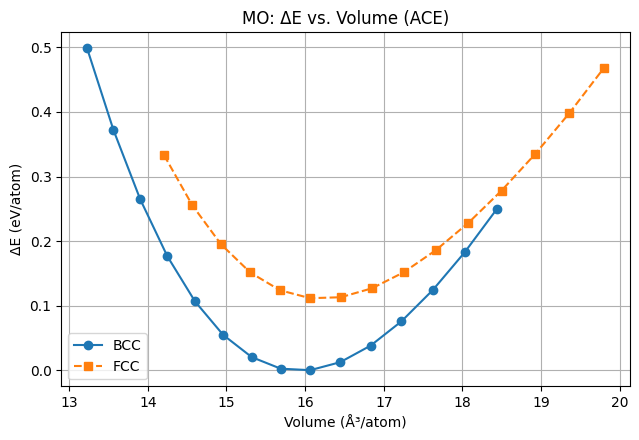

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from ase.build import bulk
import os

# === Setup ===
element = "Mo"
a0_bcc = 3.170
a0_fcc = 4.09
scaling_factors = np.linspace(0.94, 1.05, 15)  # example: ±6% around a0

# Potential path
potential_path = "/ACEcalculator&MACE MP A13 benchmarks/Mo/Mo_Dataset_order4_totaldegree9_rcut4.5_Mo_random_disp_aug_of_evwindowbccfcc_m2_delta0.4&of_relaxedvacancy250.json"






# Load ACE calculator
calc = ACE1(potential_path)

# === Energy vs Volume ===
def compute_e_vs_v(crystal, a0):
    volumes, energies = [], []
    for scale in scaling_factors:
        atoms = bulk(element, crystal, a=a0 * scale)
        atoms.calc = calc
        E_per_atom = atoms.get_potential_energy() / len(atoms)
        V_per_atom = atoms.get_volume() / len(atoms)
        volumes.append(V_per_atom)
        energies.append(E_per_atom)
    return np.array(volumes), np.array(energies)

# Compute curves
vol_bcc, en_bcc = compute_e_vs_v("bcc", a0_bcc)
vol_fcc, en_fcc = compute_e_vs_v("fcc", a0_fcc)

# === Shift to DeltaE (relative to BCC minimum) ===
E_ref = en_bcc.min()
delta_en_bcc = en_bcc - E_ref
delta_en_fcc = en_fcc - E_ref

# === Save to CSV (name based on model) ===
model_name = os.path.splitext(os.path.basename(potential_path))[0]
out_csv = f"DeltaE_vs_V_Mo_{model_name}.csv"

df = pd.DataFrame({
    "V_BCC": vol_bcc,
    "DeltaE_BCC": delta_en_bcc,
    "V_FCC": vol_fcc,
    "DeltaE_FCC": delta_en_fcc
})
df.to_csv(out_csv, index=False)
print(f"Saved ΔE–V data to {out_csv}")

# === Plot ===
plt.figure(figsize=(6.5, 4.5))
plt.plot(vol_bcc, delta_en_bcc, 'o-', label="BCC")
plt.plot(vol_fcc, delta_en_fcc, 's--', label="FCC")
plt.xlabel("Volume (Å³/atom)")
plt.ylabel("ΔE (eV/atom)")
plt.title(f"{element.upper()}: ΔE vs. Volume (ACE)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


#### Vacancy formation energy

In [ ]:
from ase.build import bulk
from ase.constraints import UnitCellFilter
from numpy.linalg import norm
from ase.optimize import BFGS
from ase.io import write
import numpy as np

# === Vacancy Formation Calculation ===

# Parameters
element = "Mo"
a0 = 3.170
supercell_size = (5, 5, 5)
fmax_tol = 1e-1

potential_path = "/ACEcalculator&MACE MP A13 benchmarks/Mo/Mo_Dataset_order4_totaldegree9_rcut4.5_Mo_random_disp_aug_of_evwindowbccfcc_m2_delta0.4&of_relaxedvacancy250.json"



# --- Build and relax bulk supercell ---
atoms_bulk = bulk(element, 'bcc', a=a0, cubic=True).repeat(supercell_size)
N_bulk = len(atoms_bulk)

atoms_bulk.calc = ACE1(potential_path)
opt_bulk = BFGS(atoms_bulk, logfile=None)
opt_bulk.run(fmax=fmax_tol)

E_bulk = atoms_bulk.get_potential_energy()
print(f"Bulk energy (N={N_bulk}): {E_bulk:.3f} eV")

# --- Create and relax vacancy structure ---
atoms_vac = atoms_bulk.copy()
atoms_vac.pop(len(atoms_vac) // 2)
atoms_vac.calc = ACE1(potential_path)

opt_vac = BFGS(atoms_vac, logfile=None)
opt_vac.run(fmax=fmax_tol)

E_vac = atoms_vac.get_potential_energy()

# --- Calculate vacancy formation energy ---
vac_E = E_vac - ((N_bulk - 1) / N_bulk) * E_bulk
print(f"Vacancy formation energy: {vac_E:.3f} eV")

Bulk energy (N=250): -2672.849 eV
Vacancy formation energy: 1.575 eV


### Nb

#### Lattice Constant

In [ ]:
from ase.build import bulk
from ase.constraints import UnitCellFilter
from numpy.linalg import norm
from ase.optimize import BFGS
from ase.io import write
import numpy as np

element_symbol = "Nb"
crystal = "bcc"
initial_lattice = 3.0
supercell = (3, 3, 3)
num_spercell_x = supercell[0]
# --- Perform structure + cell optimization ---
atoms = bulk(element_symbol, crystal, a=initial_lattice)*supercell


potential_path = "/ACEcalculator&MACE MP A13 benchmarks/Nb/Nb_Dataset_order4_totaldegree9_rcut4.5_Nb_random_disp_aug_of_evwindowbccfcc_m2_delta0.4&of_relaxedvacancy250.json"


atoms.calc = ACE1(potential_path)

ucf = UnitCellFilter(atoms, hydrostatic_strain=True)
opt = BFGS(ucf, trajectory="cell_relax.traj", logfile="cell_relax.log")
opt.run(fmax=0.01)

# --- Output relaxed cell and lattice constant ---
relaxed_cell = atoms.get_cell()

relaxed_a = atoms.get_cell()[0][0]/(num_spercell_x/2)


print("Relaxed cell:\n", relaxed_cell)
print(f"Relaxed lattice constant a = {relaxed_a:.5f} Å")

write("relaxed_cell.xyz", atoms)


/tmp/ipython-input-759953193.py:23: FutureWarning: Import UnitCellFilter from ase.filters
  ucf = UnitCellFilter(atoms, hydrostatic_strain=True)


Relaxed cell:
 Cell([[-4.9713498539538925, 4.971349853953919, 4.971349853953919], [4.9713498539538925, -4.971349853953919, 4.971349853953852], [4.9713498539538925, 4.971349853953852, -4.971349853953923]])
Relaxed lattice constant a = -3.31423 Å


#### Cubic elastic constants

In [ ]:
import numpy as np
from ase.build import bulk
from ase.units import GPa
from copy import deepcopy
from ase.optimize import BFGS
from ase.calculators.calculator import Calculator
import os

potential_path = "/ACEcalculator&MACE MP A13 benchmarks/Nb/Nb_Dataset_order4_totaldegree9_rcut4.5_Nb_random_disp_aug_of_evwindowbccfcc_m2_delta0.4&of_relaxedvacancy250.json"



# === Julia Setup ===
from julia.api import Julia
jl = Julia(compiled_modules=False)
from julia import Main
# ---------------------------
# Setup: Load model and atoms
# ---------------------------
atoms = bulk("Nb", "bcc", a=3.313)
atoms.calc = ACE1(potential_path)

E0 = atoms.get_potential_energy()
V0 = atoms.get_volume()

# ---------------------------
# Helper Functions
# ---------------------------
def apply_strain(atoms, strain_matrix):
    strained_atoms = atoms.copy()
    cell = strained_atoms.get_cell()
    new_cell = cell @ (np.eye(3) + strain_matrix)
    strained_atoms.set_cell(new_cell, scale_atoms=True)
    strained_atoms.calc = ACE1(potential_path)  # Reassign ACE calculator
    return strained_atoms


def fit_elastic_constant(strain_list, energy_list, factor=1.0):
    x = np.array([d**2 for d in strain_list])
    y = np.array(energy_list)
    coeffs = np.polyfit(x, y, 1)
    A = coeffs[0]
    #return 2 * A / factor
    return A / factor

# ---------------------------
# C11: Uniaxial strain in xx
# ---------------------------
deltas = np.linspace(-0.005, 0.005, 10)
E_C11 = []

for delta in deltas:
    strain = np.zeros((3, 3))
    strain[0, 0] = delta
    strained = apply_strain(atoms, strain)
    E = strained.get_potential_energy()
    E_C11.append((E - E0) / V0)

C11 = fit_elastic_constant(deltas, E_C11, factor=1/2)

# ---------------------------
# C12: Orthorhombic strain
# ---------------------------
E_C12 = []

for delta in deltas:
    strain = np.zeros((3, 3))
    strain[0, 0] = delta
    strain[1, 1] = -delta
    strained = apply_strain(atoms, strain)
    E = strained.get_potential_energy()
    E_C12.append((E - E0) / V0)

C11_minus_C12 = fit_elastic_constant(deltas, E_C12, factor=1.0)
C12 = C11 - C11_minus_C12

# ---------------------------
# C44: Shear strain (xy)
# ---------------------------
E_C44 = []

for delta in deltas:
    strain = np.zeros((3, 3))
    strain[0, 1] = strain[1, 0] = delta  # symmetric shear
    strained = apply_strain(atoms, strain)
    E = strained.get_potential_energy()
    E_C44.append((E - E0) / V0)

C44 = fit_elastic_constant(deltas, E_C44, factor=2.0)

# ---------------------------
# Convert and Print
# ---------------------------
eV_per_A3_to_GPa = GPa

print("\nElastic Constants (from ACE model):")
print(f"C11 ≈ {C11 / eV_per_A3_to_GPa:.2f} GPa")
print(f"C12 ≈ {C12 / eV_per_A3_to_GPa:.2f} GPa")
print(f"C44 ≈ {C44 / eV_per_A3_to_GPa:.2f} GPa")



Elastic Constants (from ACE model):
C11 ≈ 198.10 GPa
C12 ≈ 135.04 GPa
C44 ≈ 46.31 GPa


#### Energy vs Volume

Saved ΔE–V data to DeltaE_vs_V_Nb_Nb_Dataset_order4_totaldegree9_rcut4.5_Nb_random_disp_aug_of_evwindowbccfcc_m2_delta0.4&of_relaxedvacancy250.csv


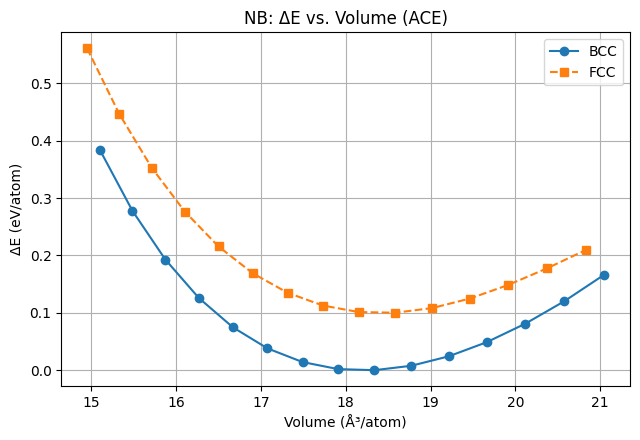

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from ase.build import bulk
import os

# === Setup ===
element = "Nb"
a0_bcc = 3.313
a0_fcc = 4.16
scaling_factors = np.linspace(0.94, 1.05, 15)  # example: ±6% around a0

# Potential path
potential_path = "/ACEcalculator&MACE MP A13 benchmarks/Nb/Nb_Dataset_order4_totaldegree9_rcut4.5_Nb_random_disp_aug_of_evwindowbccfcc_m2_delta0.4&of_relaxedvacancy250.json"







# Load ACE calculator
calc = ACE1(potential_path)

# === Energy vs Volume ===
def compute_e_vs_v(crystal, a0):
    volumes, energies = [], []
    for scale in scaling_factors:
        atoms = bulk(element, crystal, a=a0 * scale)
        atoms.calc = calc
        E_per_atom = atoms.get_potential_energy() / len(atoms)
        V_per_atom = atoms.get_volume() / len(atoms)
        volumes.append(V_per_atom)
        energies.append(E_per_atom)
    return np.array(volumes), np.array(energies)

# Compute curves
vol_bcc, en_bcc = compute_e_vs_v("bcc", a0_bcc)
vol_fcc, en_fcc = compute_e_vs_v("fcc", a0_fcc)

# === Shift to DeltaE (relative to BCC minimum) ===
E_ref = en_bcc.min()
delta_en_bcc = en_bcc - E_ref
delta_en_fcc = en_fcc - E_ref

# === Save to CSV (name based on model) ===
model_name = os.path.splitext(os.path.basename(potential_path))[0]
out_csv = f"DeltaE_vs_V_Nb_{model_name}.csv"

df = pd.DataFrame({
    "V_BCC": vol_bcc,
    "DeltaE_BCC": delta_en_bcc,
    "V_FCC": vol_fcc,
    "DeltaE_FCC": delta_en_fcc
})
df.to_csv(out_csv, index=False)
print(f"Saved ΔE–V data to {out_csv}")

# === Plot ===
plt.figure(figsize=(6.5, 4.5))
plt.plot(vol_bcc, delta_en_bcc, 'o-', label="BCC")
plt.plot(vol_fcc, delta_en_fcc, 's--', label="FCC")
plt.xlabel("Volume (Å³/atom)")
plt.ylabel("ΔE (eV/atom)")
plt.title(f"{element.upper()}: ΔE vs. Volume (ACE)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


#### Vacancy formation energy

In [ ]:
from ase.build import bulk
from ase.constraints import UnitCellFilter
from numpy.linalg import norm
from ase.optimize import BFGS
from ase.io import write
import numpy as np

# === Vacancy Formation Calculation ===

# Parameters
element = "Nb"
a0 = 3.313
supercell_size = (5, 5, 5)
fmax_tol = 1e-1

potential_path = "/ACEcalculator&MACE MP A13 benchmarks/Nb/Nb_Dataset_order4_totaldegree9_rcut4.5_Nb_random_disp_aug_of_evwindowbccfcc_m2_delta0.4&of_relaxedvacancy250.json"



# --- Build and relax bulk supercell ---
atoms_bulk = bulk(element, 'bcc', a=a0, cubic=True).repeat(supercell_size)
N_bulk = len(atoms_bulk)

atoms_bulk.calc = ACE1(potential_path)
opt_bulk = BFGS(atoms_bulk, logfile=None)
opt_bulk.run(fmax=fmax_tol)

E_bulk = atoms_bulk.get_potential_energy()
print(f"Bulk energy (N={N_bulk}): {E_bulk:.3f} eV")

# --- Create and relax vacancy structure ---
atoms_vac = atoms_bulk.copy()
atoms_vac.pop(len(atoms_vac) // 2)
atoms_vac.calc = ACE1(potential_path)

opt_vac = BFGS(atoms_vac, logfile=None)
opt_vac.run(fmax=fmax_tol)

E_vac = atoms_vac.get_potential_energy()

# --- Calculate vacancy formation energy ---
vac_E = E_vac - ((N_bulk - 1) / N_bulk) * E_bulk
print(f"Vacancy formation energy: {vac_E:.3f} eV")

Bulk energy (N=250): -2520.569 eV
Vacancy formation energy: 1.330 eV
